# Synthesis Imaging 

This chapter documents CASA's refactored imager. These features are visible to the user via the **tclean** task. Image products can be visualized with the CASA Viewer, which in CASA 6 should be initialized with the task **imview**.

The first five sections give an algorithm-centric view of the imager framework and are meant to convey the overall iterative reconstruction framework and how various algorithms and usage options fit into it. The other sections are more user-centric and focus on what one would need to know about specific imaging goals such as wideband imaging, mosaicking or details about spectral-cube definitions, etc. There is some overlap in content between sections, but this is meant to address the needs of readers who want to understand how the system works as well as those who want to learn how to approach their specific use case.




## Introduction 

Image reconstruction in radio interferometry is the process of solving the linear system of equations $\vec{V} = [A] \vec{I}$, where $\vec{V}$ represents visibilities calibrated for direction independent effects, $\vec{I}$ is a list of parameters that model the sky brightness distribution (for example, a image of pixels) and $[A]$ is the measurement operator that encodes the process of how visibilities are generated when a telescope observes a sky brightness $\vec{I}$.  $[A]$ is generally given by $[S_{dd}][F]$ where $[F]$ represents a 2D Fourier transform, and $[S_{dd}]$ represents a 2D spatial frequency sampling function that can include direction-dependent instrumental effects. For a practical interferometer with a finite number of array elements, $[A]$ is non-invertible because of unsampled regions of the $uv$ plane. Therefore, this system of equations must be solved iteratively, applying constraints via various choices of image parameterizations and instrumental models.

**Implementation ( major and minor cycles ):**

Image reconstruction in CASA comprises an outer loop of *major cycles* and an inner loop of *minor cycles*. The major cycle implements transforms between the data and image spaces and the minor cycle operates purely in the image domain. Together, they implement an iterative weighted $\chi^2$ minimization process that solves the measurement equation.

 

![26ad14d4f63ff633dbd5d9e92d40a5059ab46a67](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/26ad14d4f63ff633dbd5d9e92d40a5059ab46a67.png?raw=1){.image-inline width="635" height="347"}

>Iterative Image Reconstruction - Major and Minor Cycles
  

 

The data to image transform is called the *imaging* step in which a pseudo inverse of $[S_{dd}][F]$ is computed and applied to the visibilities. Operationally, weighted visibilities are convolutionally resampled onto a grid of spatial-frequency cells, inverse Fourier transformed, and normalized. This step is equivalent to calculating the normal equations as part of a least squares solution. The image to data transform is called the *prediction* step and it evaluates the measurement equation to convert a model of the sky brightness into a list of model visibilities that are later subtracted from the data to form residual visibilities. For both transforms, direction dependent instrumental effects can be accounted for via carefully constructed convolution functions.

Iterations begin with an initial guess for the image model.  Each major cycle consists of the prediction of model visibilities, the calculation of residual visibilities and the construction of a residual image. This residual image contains the effect of incomplete sampling of the spatial-frequency plane but is otherwise normalized to the correct sky flux units. In its simplest form, it can be written as a convolution of the true sky image with a point spread function. The job of the minor cycle is to iteratively build up a model of the true sky by separating it from the point spread function. This step is also called *deconvolution* and is equivalent to the process of solving the normal equations as part of a least squares solution. Different reconstruction algorithms can operate as minor cycle iterations, allowing for flexibility in (for example) how the sky brightness is parameterized. The imaging step can be approximate in that several direction dependent effects, especially baseline, frequency or time-dependent ones can sometimes  ignored, minor cycles can be approximate in that they use only PSF patches and do not try to be accurate over the entire image, but the prediction step of the major cycle must be as accurate as possible such that model components are converted to visibilities by including all possible instrumental effects.

**Basic Sequence of Imaging Logic:**

```
Data : Calibrated visibilities, data weights, UV sampling function
Input : Algorithm and iteration controls (stopping threshold, loop gain,...)
Output : Model Image, Restored Image, Residual Image,...

Initialize the model image
Compute the point spread function
Compute the initial residual image
While ( not reached global stopping criterion )             /* Major Cycle */
{
    While ( not reached minor-cycle stopping criterion )    /* Minor Cycle */
    {
        Find the parameters of a new flux component
        Update the model and residual images
    }
    Use current model image to predict model visibilities
    Calculate residual visibilities (data - model)
    Compute a new residual image from residual visibilities
}
Convolve the final model image with the fitted beam and add to the residual image
```

**Algorithmic Options :**

Within the CASA implementation, numerous choices are provided to enable the user to fine-tune the details of their image reconstruction. Images can be constructed as spectral cubes with multiple frequency channels or single-plane wideband continuum images. One or more sub images may be defined to cover a wide field of view without incurring the computational expense of very large images. The iterative framework described above is based on the Cotton-Schwab Clean algorithm [\[3\]](#Bibliography), but variants like Hogbom Clean [\[1\]](#Bibliography) and Clark Clean [\[2\]](#Bibliography) are available as subsets of this framework. The major cycle allows controls over different data weighting schemes [\[10\]](#Bibliography) and convolution functions that account for wide-field direction-dependent effects during imaging and prediction \[[\[6\]](#Bibliography), [\[7\]](#Bibliography) , [\[8\]](#Bibliography)\]. Deconvolution options include the use of point source vs multi-scale image models [\[4\]](#Bibliography) , narrow-band or wide-band models [\[5\]](#Bibliography), controls on iteration step size and stopping criteria, and external constraints such as interactive and non-interactive image masks. Mosaics may be made with data from multiple pointings, either with each pointing imaged and deconvolved separately before being combined in a final step, or via a joint imaging and deconvolution [\[9\]](#Bibliography). Options to combine single dish and interferometer data during imaging also exist. More details about these algorithms can be obtained from \[[\[10\]](#Bibliography), [\[11\]](#Bibliography), [\[12\]](#Bibliography), [\[13\]](#Bibliography)\] 

 

 



## Types of images 

Ways to set up images (Cube vs MFS, single field, outliers, facets, Stokes planes ) and select data

The visibility data can be selected in many ways and imaged separately (e.g. one spectral window, one field, one channel). Data selection can also be done in the image-domain where the same data are used to create multiple image planes or multiple images (e.g. Stokes I,Q,U,V, or Taylor-polynomial coefficients or multiple-facets or outlier fields).

Parameters for data selection and image definition together define the following options.

Data Selection | Imaging Definition
--- | ---
Spectral Axis | Cube (multiple channels)  or  MFS (single wideband channel) or MT-MFS (multi-term wideband images)
Polarization axis | Stokes Planes ( I, IV, IQUV, pseudoI, RR, LL, XX, YY, etc )
Sky Coordinates | Image shape, cell size, phasecenter, with or without outlier fields
Data Selection | One pointing vs multiple pointings for a mosaic, data from multiple MeasurementSets, etc.

For the most part, the above axes are independent of each other and logical (and useful) combinations of them are allowed. For example, spectral cubes or wideband multi-term images can have outlier fields and/or mosaics. An example of a prohibited combination is the use of facets along with mosaics or a-projection as their algorithmic requirements contradict each other.


**Spectral Cubes:**

During gridding, N Data channels are binned onto M image channels using several optional interpolation schemes and doppler corrections to transform the data into the LSRK reference frame. When data from multiple channels are mapped to a single image channel, multi-frequency-synthesis gridding is performed within each image channel. More details are explained on the [Spectral Line Imaging](synthesis_imaging.ipynb#spectral-line-imaging) page. As can be seen from the diagram, parallelization for cube imaging can be naturally done by partitioning data and image planes by frequency for both major and minor cycles.


![7712e396f0309a7d9309a77cfa8fc6fc2f8a0be9](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/7712e396f0309a7d9309a77cfa8fc6fc2f8a0be9.png?raw=1){.image-inline width="460" height="257"}


**Continuum Images**

Wideband imaging involves mapping data from a wide range of frequency channels onto a single image channel.

*Multi Frequency Synthesis (MFS) - Single Wideband Image*

Data from all selected data channels are mapped to a single broadband uv-grid using appropriate uvw coordinates, and then imaged. This is accessed via the \" *specmode=\'mfs\'* \" option in the **tclean** task. Since there is only one uv grid and image, parallelization for continuum imagng is done only for the major cycle via data partitioning.

![51885b785409ea1448f61c399eb82e53f0a54729](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/51885b785409ea1448f61c399eb82e53f0a54729.png?raw=1){.image-inline width="429" height="216"}

 

*Multi-Term Multi Frequency Synthesis (MTMFS) - Taylor Coefficient Images*

An improvement to standard MFS that accounts for changes in spectral index as a function of sky position is available that uses Taylor weighted averages of data from all frequencies accumulated onto NTerms uv-grids before imaging. These Taylor-weighted residual images form the input for the minor cycle of the Multi-Term MFS deconvolution algorithm which performs a linear least squares fit (see [Deconvolution Algorithms](synthesis_imaging.ipynb#deconvolution-algorithms) section for more information) during deconvolution to obtain Taylor Coefficients per component (to represent sky spectra as polynomials in $I$ vs $\nu$). This option is accessed via \" *specmode=\'mfs\'* and *deconvolver*=\'mtmfs\', *nterms=2.* \" For the same data size as standard MFS (*nterms=1*), Multi-Term MFS will have $N_t$ times the gridding cost and number of images stored in memory.  Parallelization is again done only for the major cycle via data partitioning.

![f068a79a636e070fea341be6847ccefc61b1c6d5](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/f068a79a636e070fea341be6847ccefc61b1c6d5.png?raw=1){.image-inline width="447" height="285"}


**Polarization Planes**

Data in the correlation basis are gridded onto separate planes per correlation, imaged, and then transformed into the Stokes basis. A special case for single plane Stokes I is implemented where data from both parallel hands are gridded onto a single uv-grid (to save memory). The point spread function is always taken from the Stokes I gridded weights. Images can be made for all Stokes parameters and correlation pairs (or all combinations possible with the selected data). This is an image-partitioning, where the same data are used to construct the different imaging products. Currently, if any correlation is flagged, all correlations for that datum are considered as flagged. An exception is the \'*pseudoI*\' option which allows Stokes I images to include data for which either of the parallel hand data are unflagged.


![2505ddafc4936705143e6210e997ffee48acf231](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/2505ddafc4936705143e6210e997ffee48acf231.png?raw=1){.image-inline width="515" height="271"}  


**Multiple Fields**

A very large field of view can sometimes be imaged as a main field plus a series of (typically) smaller outlier fields. Imaging of fields with relatively few bright outlier sources can benefit from the overal reduction in image size that this option provides.  Instead of gridding the visibilities data onto a giant uv-grid, they are gridded onto multiple smaller images. Each sub-image is then deconvolved via separate minor cycles and their model images combined to predict model visibiliitles to subtract from the data in the next major cycle. The user must specify different phase reference centers for each image field.

Different image shapes and gridding and deconvolution algorithms can be chosen for the different outlier fields. For example, one could apply single-plane wideband imaging on the main field, but employ multi-term MFS for an outlier field to account for artificial spectral index due to the wideband primary beam at its location. One can also combine MFS and Cube shapes for different outlier fields, or choose to run Multi-Scale CLEAN on the main field and Hogbom CLEAN on a bright compact outlier.    

Overlapping fields are supported when possible (i.e. when the image types are similar enough across outliers) by always picking the \"last\" instance of that source in the list of outlier images in the order specified by the user. This convention implies that sources in the overlapping area are blanked in the \"earlier\" model images, such that those sources are not subtracted during the major cycles that clean those images.


![5c981ca63d45b330b41ebcd4e67b4607d47d47a5](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/5c981ca63d45b330b41ebcd4e67b4607d47d47a5.png?raw=1){.image-inline width="479" height="249"}


**Multiple Facets**

Faceted imaging is one way of handling the w-term effect. A list of facet-centers is used to grid the data separately onto multiple adjacent sub-images. The sub images are typically simply subsets of a single large image so that the deconvolution can be performed as a joint image and a single model image is formed. The PSF to be used for deconvolution is picked from the first facet. The list of phase reference centers for all facets is automatically generated from user input of the number of facets (per side) that the image is to be divided into.


![08fa4167833923aa5e120ade2d66c24de84c3a4a](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/08fa4167833923aa5e120ade2d66c24de84c3a4a.png?raw=1){.image-inline width="513" height="272"}


**Mosaics**

Data from multiple pointings can be combined to form a single large image. The combination can be done either before/during imaging or after deconvolution and reconstruction.

*Stitched Mosaic*

Data from multiple pointings are imaged and deconvolved separately, with the final output images being combined using a primary beam model as a weight. This is achieved by running the imaging task (**tclean**) separately per pointing, and combining them later on using the tool **im.linearmosaic**().

![64ef9fbb940c0eefc34e96c18d0ac726f56ee982](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/64ef9fbb940c0eefc34e96c18d0ac726f56ee982.png?raw=1){.image-inline width="467" height="226"}


*Joint Mosaic*

Data taken with multiple pointings (and/or phase-reference centres) can be combined during imaging by selecting data from all fields together (multiple field-ids), and specifying only one output image name and one phase-reference center. If mosaic mode is enabled (*gridder=\'mosaic\'* or *\'awproject\'*) attention is paid to the pointing centers of each data-fieldID during gridding. Primary-beam models are internally used during gridding (to effectively weight the images that each pointing would produce during a combination) and one single image is passed on to the deconvolution modules. 


![0886eddf2dfd68343993dca5b5c02affe00ccc54](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/0886eddf2dfd68343993dca5b5c02affe00ccc54.png?raw=1){.image-inline width="448" height="218"}


***





 



## Imaging Algorithms 

Imaging is the process of converting a list of calibrated visiblities into a raw or \'dirty\' image. There are three stages to inteferometric image-formation: weighting, convolutional resampling, and a Fourier transform.




### Data Weighting

During imaging, the visibilities can be weighted in different ways to alter the instrument\'s natural response function in ways that make the image-reconstruction tractable.

Data weighting during imaging allows for the improvement of the dynamic range and the ability to adjust the synthesized beam associated with the produced image. The weight given to each visibility sample can be adjusted to fit the desired output. There are several reasons to adjust the weighting, including improving sensitivity to extended sources or accounting for noise variation between samples. The user can adjust the weighting using **tclean** and changing the *weighting* parameter with six options: \'natural\', \'uniform\', \'briggs\',  \'superuniform\', \'briggsabs\', and \'radial\'. Optionally, a UV taper can be applied, and various parameters can be set to further adjust the weight calculations.


**Natural weighting**

The natural weighting scheme gives equal weight to all samples. Since usually, lower spatial frequencies are sampled more often than the higher ones, the inner uv-plane will have a significantly higher density of samples and hence signal-to-noise than the outer uv-plane. The resulting \"density-upweighting\" of the inner uv-plane will produce the largest angular resolution and can sometimes result in undesirable structure in the PSF which reduces the accuracy of the minor cycle. However, at the location of a source, this method preserves the natural point-source sensitivity of the instrument.

For *weighting=\'natural\'*, visibilities are weighted only by the data weights, which are calculated during filling and calibration and should be equal to the inverse noise variance on that visibility. Imaging weight $w_i$ of sample $\dot\imath$ is given by:

$w_i = \omega_i = \frac{1}{{\sigma_i}^2}$

where the data weight $\omega_i$ is determined from $\sigma_i$, the rms noise on visibility $\dot\imath$. When data is gridded into the same uv-cell for imaging, the weights are summed, and thus a higher uv density results in higher imaging weights. No sub-parameters are linked to this mode choice. It is the default imaging weight mode, and it should produce "optimum" image with with the lowest noise (highest signal-to-noise ratio).

<div class="alert alert-info">
**NOTE**: This generally produces images with the poorest angular resolution, since the density of visibilities falls radially in the uv-plane.
</div>


**Uniform weighting**

Uniform weighting gives equal weight to each measured spatial frequency irrespective of sample density. The resulting PSF has the narrowest possible main lobe (i.e. smallest possible angular resolution) and suppressed sidelobes across the entire image and is best suited for sources with high signal-to-noise ratios to minimize sidelobe contamination between sources. However, the peak sensitivity is significantly worse than optimal (typically \~20% worse for reasonably large number of antenna interferometers), since data points in densely sampled regions have been weighted down to make the weights uniform. Also, isolated measurements can get artifically high relative weights and this may introduce further artifacts into the PSF.

For *weighting=\'uniform\'*, the data weights are calculated as in \'natural\' weighting. The data is then gridded to a number of cells in the uv-plane, and after all data is gridded the uv-cells are re-weighted to have "uniform" imaging weights. This pumps up the influence on the image of data with low weights (they are multiplied up to be the same as for the highest weighted data), which sharpens resolution and reduces the sidelobe level in the field-of-view, but increases the rms image noise. No sub-parameters are linked to this mode choice.

For uniform weighting, we first grid the inverse variance $\omega_i$ for all selected data onto a grid with uv cell-size given by 2 ∕ FOV, where FOV is the specified field of view (defaults to the image field of view). This forms the gridded weights $W_k$. The weight of the $\dot\imath$-th sample is then:

$w_i = \frac{\omega_i}{W_k}$


**Briggs weighting**

Briggs or Robust weighting [\[14\]](#Bibliography) creates a PSF that smoothly varies between natural and uniform weighting based on the signal-to-noise ratio of the measurements and a tunable parameter that defines a noise threshold. High signal-to-noise samples are weighted by sample density to optimize for PSF shape, and low signal-to-noise data are naturally weighted to optimize for sensitivity.

The *weighting=\'briggs\' *mode is an implementation of the flexible weighting scheme developed by Dan Briggs in his PhD thesis, which can be viewed [here](http://www.aoc.nrao.edu/dissertations/dbriggs/).

This choice brings up the sub-parameters:

```
weighting      =   'briggs'   #Weighting to apply to visibilities  
     robust    =        0.0   #Briggs robustness parameter  
     npixels   =          0   #number of pixels to determine uv-cell size 0=> field of view
```

The actual weighting scheme used is:

$w_i = \frac{\omega_i}{1 + W_k f^2}$

where

$w_i$ is the image weight for a given visibility point $i$;

$\omega_i$ is the visibility weight for a given visibility point $i$;

$W_k = \Sigma_{cell=k}\,\omega_{k}$ is the weight density of a given cell $k$ (with $\omega_{k}$ the weight of a uv point that falls in cell $k$). When using *npixels \> 0* then $\Sigma_{\omega_{k}}$ is over all weights that fall in cells in range *k ± npixels*

$f^2 = \frac{(5 \times 10^{-\text{R}})^2}{\frac{\Sigma_k W_k^2}{\Sigma_i \omega_i}}$;

R is the robust sub-parameter.

The key parameter is the *robust sub-*parameter, which sets R in the Briggs equations. The scaling of R is such that *robust=0* gives a good trade-off between resolution and sensitivity. The robust R takes value between -2.0 (close to uniform weighting) to 2.0 (close to natural).

Superuniform weighting can be combined with Briggs weighting using the *npixels *sub-parameter. This works as in 'superuniform' weighting.


**Briggsabs weighting**

Briggsabs is an experimental weighting scheme that is an adapted version of the Briggs weighting scheme, and is much more aggressive with respect to changes in *npixels*, the uv-cell size.

For *weighting=\'briggsabs\'*, a slightly different Briggs weighting is used, with:

$w_i = \frac{\omega_i}{W_k \text{R}^2 + 2\sigma_\text{i}^2}$

where R is the *robust* parameter and $\sigma_\text{i}$ is the *noise *parameter. In this case, R makes sense for −2.0 ≤ R ≤ 0.0 (R = 1.0 will give the same result as R = −1.0)

This choice brings up the sub-parameters:

```
weighting      = 'briggsabs'  #Weighting to apply to visibilities  
     robust    =      0.0     #Briggs robustness parameter  
     noise     =  '0.0Jy'     #noise parameter for briggs weighting when rmode='abs' 
     npixels   =        0     #number of pixels to determine uv-cell size 0=> field of view
```

<div class="alert alert-warning">
**WARNING:** Briggsabs weighting is experimental - use at own risk!
</div>


**Superuniform weighting**

The *weighting='superuniform'* mode is similar to the \'uniform\' weighting mode but there is now an additional *npixels *sub-parameter that specifies a change to the number of cells on a side (with respect to uniform weighting) to define a uv-plane patch for the weighting renormalization. If *npixels=0*, you get uniform weighting.


**Radial weighting**

The *weighting='radial'* mode is a seldom-used option that increases the weight by the radius in the uv-plane, i.e.:

$w_i = \omega_i \times \sqrt{u_i^2 + v_i^2}$

Technically, this would be called an inverse uv-taper, since it depends on uv-coordinates and not on the data per-se. Its effect is to reduce the rms sidelobes for an east-west synthesis array. This option has limited utility.


**Perchanweightdensity**

When calculating weight density for Briggs style weighting in a cube, the *perchanweightdensity* parameter determines whether to calculate the weight density for each channel independently (the default, True) or a common weight density for all of the selected data. This parameter has no meaning for continuum (*specmode='mfs'*) imaging but for cube imaging *perchanweightdensity=True* is a recommended  alternative option that provides more uniform sensitivity per channel for cubes, but with generally larger psfs than the *perchanweightdensity=False* option (which was also the behavior prior to CASA 5.5). When using *Briggs* style weight with *perchanweightdensity=True*, the imaging weight density calculations use only the weights of data that contribute specifically to that channel. On the other hand, when *perchanweightdensity=False*, the imaging weight density calculations sum all of the weights from all of the data channels selected whose (u,v) falls in a given uv cell on the weight density grid. Since the aggregated weights, in any given uv cell, will change depending on the number of channels included when imaging, the psf calculated for a given frequency channel will also necessarily change, resulting in variability in the psf for a given frequency channel when *perchanweightdensity=False*. In general, *perchanweightdensity=False* results in smaller psfs for the same value of robustness compared to *perchanweightdensity=True*, but the rms noise as a function of channel varies and increases toward the edge channels; *perchanweightdensity=True* provides more uniform sensitivity per channel for cubes. This may make it harder to find estimates of continuum when *perchanweightdensity=False*. If you intend to image a large cube in many smaller subcubes and subsequently concatenate, it is advisable to use *perchanweightdensity=True* to avoid surprisingly varying sensitivity and psfs across the concatenated cube.

<div class="alert alert-info">
**NOTE**: Setting *perchanweightdensity = True* only has effect when using *Briggs* (robust) or *uniform* weighting to make an image cube. It has no meaning for *natural* and *radial* weighting in data cubes, nor does it have any meaning for continuum (*specmode='mfs'*) imaging.
</div>


**Mosweight**

When doing Brigg\'s style weighting (including uniform) in **tclean**, the *mosweight* subparameter of the mosaic gridder determines whether to weight each field in a mosaic independently (*mosweight = True*), or to calculate the weight density  from the average uv distribution of all the fields combined (*mosweight = False*). The underlying issue with more uniform robust weighting is how the weight density maps onto the uv-grid, which can give high weight to areas of the uv-plane that are not actually more sensitive. The setting *mosweight = True* has long been known as potentially useful in cases where a mosaic has non-uniform sensitivity, but it was found that it is also very important for more uniform values of robust Briggs weighting in the presence of relatively poor uv-coverage. For example, snap-shot ALMA mosaics with *mosweight = False* typically show an increase in noise in the corners or in the areas furthest away from the phase-center. Therefore, as of CASA 5.4, the *mosweight* sub-parameter has been added to **tclean** with default value *mosweight = True*.

<div class="alert alert-warning">
**WARNING:** the default setting of *mosweight=True* under the mosaic gridder in **tclean** has the following disadvantages: (1) it may potentially cause memory issues for large VLA mosaics; (2) the major and minor axis of the synthesized beam may be ~10% larger than with mosweight=False. Please change to *mosweight=False* to get around these issues.
</div>


**uvtaper**

The effect of uvtaper this is that the clean beam becomes larger, and surface brightness sensitivity increases for extended emission.

uv-tapering applies a Gaussian taper on the weights of your UV data, in addition to the weighting scheme specified via the \'weighting\' parameter. It applies a multiplicative Gaussian taper to the spatial frequency grid, to weight down high spatial-frequency measurements relative to the rest. This means that higher spatial frequencies are weighted down relative to lower spatial frequencies, to suppress artifacts arising from poorely sampled regions near and beyond the maximum spatial frequency in the uv-plane. It is equivalent to smoothing the PSF obtained by other weighting schemes and can be specified either as a Gaussian in uv-space (eg. units of lambda or klambda) or as a Gaussian in the image domain (eg. angular units like arcsec). Because the natural PSF is smoothed out, this tunes the sensitivity of the instrument to scale sizes larger than the angular-resolution of the instrument by increasing the width of the main lobe. There are limits to how much uv-tapering is desirable, however, because the sensitiivty will decrease as more and more data is down-weighted.

<div class="alert alert-info">
**NOTE**: The on-sky FWHM in arcsec is roughly the *uvtaper* / 200 (klambda).
</div>

Examples: 

```
uvtaper=['5klambda'] circular taper FWHM=5 kilo-lambda, 
uvtaper=['5klambda','3klambda','45.0deg'], 
uvtaper=['10arcsec'] on-sky FWHM 10 arcseconds, 
uvtaper=['300.0'] default units are lambda in aperture plane, 
uvtaper=[]; no outer taper applied (default)
```

![6178646282cf25c3d316aa14c3d888e6608a49bd](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/6178646282cf25c3d316aa14c3d888e6608a49bd.png?raw=1){.image-inline width="497" height="312"}



### Gridding + FFT

Imaging weights and weighted visibilities are first resampled onto a regular uv-grid (convolutional resampling) using a prolate-spheroidal function as the gridding convolution function (GCF). The result is then Fourier-inverted and grid-corrected to remove the image-domain effect of the GCF. The PSF and residual image are then normalized by the sum-of-weights.

![29159db628f096f12291870d788317a84a86e15c](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/29159db628f096f12291870d788317a84a86e15c.png?raw=1){.image-inline width="271" height="277"}
 

**Direction-dependent corrections**

Basic gridding methods use prolate spheroidals for gridding (*gridder='standard'*) along with image-domain operations to correct for direction-dependent effects. More sophisticated, and computationally-intensive methods (*gridder='wproject','widefield','mosaic','awproject'*) apply direction-dependent, time-variable and baseline-dependent corrections during gridding in the visibility-domain, by choosing/computing the appropriate gridding convolution kernel to use along with the imaging-weights.

The figure below shows examples of kernels used for the following gridding methods: Standard, W-Projection, and A-Projection.  Combinations of wide-field corrections are done by convolving these kernels together.  For example, AW-Projection will convolve W-kernels with baseline aperture functions and possibly include a prolate spheroidal as well for its anti-aliasing properties.   Mosaicing is implemented as a phase gradient across the gridding convolution kernel calculated at the uv-cell resolution dictated by the full mosaic image size.

In tclean, *gridder='mosaic'* uses Airy disk or polynomial models to construct azimuthally symmetric beams per antenna that are transformed into baseline convolution functions and used for gridding.  *gridder='awproject'* uses ray-traced models of antenna aperture illumination functions to construct GCFs per baseline and time (including azimuthal asymmetry, beam squint, and rotation with time).  More details are given in the [Wide Field Imaging](synthesis_imaging.ipynb#wide-field-imaging) section.


![1c48e6447847e5f2e25d16da48fb67f74b5e0a70](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/1c48e6447847e5f2e25d16da48fb67f74b5e0a70.png?raw=1){.image-inline width="668" height="353"}


Computing costs during gridding scale directly with the number of pixels needed to accurately describe each convolution kernel. The standard gridding kernel (prolate spheroid) typically has 3x3 pixels. W-Projection kernels can range from 5x5 to a few hundred pixels on a side.  A-Projection kernels typically range from 8x8 to 50x50 pixels.  When effects are combined by convolving together different kernels (for example A and W Projection), the kernel sizes increase accordingly. 

Memory (and one-time computing costs) also scale with the number of distinct kernels that one must operate with. For example, a large number of different W-Projection kernels, or an array whose antenna illumination patterns are different enough between antennas that they need to be treated separately. In the case of a heterogenous array, each baseline illumination function can be different.  Additionally, if any of these aperture illumination based kernels are rotationally asymmetric, they will need to be rotated (or recomputed at different parallactic angles) as a function of time.  





### Normalization

After gridding and the FFT, images must be normalized (by the sum of weights, and optionally by some form of the primary beam weights) to ensure that the flux in the images represents sky-domain flux.

**Sum-Of-Weights and Weight Images**

The tclean task produces a number of output images used for normalization. The primary reason these are explicit images on disk (and not just internal temporary files in memory) is that for continuum paralellization, there is the need to accumulate numerators and denominators separately before the normalization step.  For the most part, end users can safely ignore the  output .weight,  .sumwt and .gridwt images.  However, their contents are documented here.

- *.sumwt* 

  A single-pixel image containing the sum-of-weights (or, the peak of the PSF). For natural weighting, this is just the sum of the data weights.  For other weighting schemes it contains the effect of the weighting algorithm. For instance, uniform weighting will typically produce a smaller sum-of-weights than natural weighting.    An approximate theoretical sensitivity can be computed as  sqrt( 1/sumwt ). A more accurate calculation requires a different calculation (LINK to some docs from GM on this).   In tclean, facetted imaging will produce one value of sumwt per facet as the normalizations are to be done separately per facet.  Also, for cube imaging, .sumwt will contain one value per image channel and it can be used to visualize the relative weights across the spectrum (and therefore expected image rms). This theoretical sensitivity information is printed to the logger after the PSF generation stage.

- *.weight*

  Projection gridders such as \'mosaic\' and \'awproject\' use baseline aperture illumination functions for gridding.  The quantity in the .weight image represents the square of the PB, accumulated over baselines, time and frequency.   For mosaics, it includes a combination across pointing as well (although as can be seen from the equations in the mosaicing section, this is not accurate when weights between pointings differ considerably).

- *.gridwt*

  A series of temporary images for cube imaging that are stored within the parallel .workdirectory, and which accumulate binned natural weights before the calculation of imaging weights.  This is not used for normalization anywhere after the initial image weighting stage.


**Normalization Steps**

- Standard Imaging

  For gridders other than \'mosaic\' and \'awproject\', normalization of the image formed after gridding and the FFT is just the division by the sum of weights (read from the .sumwt image). This suffices to transform the image into units of sky brightness. This is the typical flat-noise normalization (see below).

- Imaging with primary beams (and mosaics)

  For *gridder=\'mosaic\'* and \'awproject\' that use baseline aperture illumination functions during gridding, the result is an additional instance of the PB in the images, which needs to be divided out.  Normalization involves three steps (a) division by the sum-of-weights (b) division by an average PB given by sqrt(weightimage) and (c) a scaling to move the peak of the PB = sqrt(weightimage) to 1.0.   This ensures that fluxes in the dirty image (and therefore those seen by the minor cycle) represent true sky fluxes in regions where the primary beam is at its peak value, or where the mosaic has a relatively constant flat sensitivity pattern.    The reverse operations of (b) and (c) are done before predicting a model image in the major cycle.   ( This description refers to flat-noise normalization, and corresponding changes are done for the other options ).


**Types of normalization**

There are multiple ways of normalizing the residual image before beginning minor cycle iterations. One is to divide out the primary beam before deconvolution and another is to divide out the primary beam from the deconvolved image. Both approaches are valid, so it is important to clarify the difference between the two. A third option is included for completeness.

For all options, the \'pblimit\' parameter controls regions in the image where PB-correction is actually computed. Regions below the pblimit cannot be normalized and are set to zero. For standard imaging, this refers only to the pb-corrected output image. For *gridder='mosaic'* and *'awproject'* it applies to the residual, restored and pb-corrected images.  A small value (e.g. *pblimit=0.01*) can be used to increase the region of the sky actually imaged. For *gridder='standard'*, there is no pb-based normalization during gridding and so the value of this parameter is ignored.The sign of the pblimit parameter is used for a different purpose. If positive, it defines a T/F pixel mask that is attached to the output residual and restored images.  If negative, this T/F pixel mask is not included.  Please note that this pixel mask is different from the deconvolution mask used to control the region where CLEAN based algorithms will search for source peaks.  In order to set a deconvolution mask based on pb level, please use the \'pbmask\' parameter.Based on the above, please note that certain values of pblimit to avoid, are 1, -1, and 0. When the pblimit is set to 1 the entire image is masked as the user is specifying that no normalization or deconvolution happens if the PB gain is lower than 1, which leads to the entire image being masked. Setting the pblimit to -1 also results in no deconvolution as mentioned in the case where pblimit is 1 but there is no masking of the image. Finally a pblimit of zero is not feasible but rather a small value such as 1e-6 is used instead to make a really large wide field image.

*Flat-noise*

The dirty image represents $I^{dirty} = I^{psf} \star \left( I^{PB} \cdot I^{sky} \right)$

Primary-beam correction is not done before the minor cycle deconvolution. The dirty image is the instrument\'s response to the product of the sky and the primary beam, and therefore the model image will represent the product of the sky brightness and the average primary beam. The noise in the image is related directly to the measurement noise due to the interferometer, and is the same all across the image. The minor cycle can give equal weight to all flux components that it finds. At the end of deconvolution, the primary beam must be divided out of the restored image. This form of normalization is useful when the primary beam is the dominant direction-dependent effect because the images going into the minor cycle satisfy a convolution equation. It is also more appropriate for single-pointing fields-of-view.

Imaging with the prolate spheroidal gridder will automatically give flat noise images.

*Flat-sky*

The dirty image represents $I^{dirty} = \frac{1}{I^{PB}} \cdot \left[I^{psf} \star \left( I^{PB} \cdot I^{sky} \right) \right]$

Approximate Primary-beam correction is done on the dirty image, before the minor cycle iterations. The amplitude of the flux components found during deconvolution will be free of the primary beam, and will represent the true sky. However, the image going into the minor cycle will not satisfy a convolution equation and the noise in the dirty image will be higher in regions where the primary-beam gain is low. Therefore, the minor cycle needs to account for this while searching for flux components (a signal-to-noise dependent CLEAN). This form of normalization is particularly useful for mosaic imaging where the sky brightness can extend across many pointings, or if there is an uneven distribution of weights across pointings. This is because joint mosaics are usually done for sources with spatial scales larger than the field-of-view of each antenna and which are not explicitly present in the measured data. In this situation, allowing the minor cycle to use flux components that span across beams of adjacent pointings is likely to provide a better constraint on the reconstruction of these unmeasured spatial frequencies, and produce smoother large-scale emission.

*PB-square normalization*

The dirty image represents $I^{dirty} = I^{PB} \cdot \left[ I^{psf} \star \left( I^{PB} \cdot I^{sky} \right) \right]$

This third option (not currenly available for use, but supported internally) is to not do any PB-based divisions after the gridding and FFT (using *gridder=\'mosaic\'* or \'awproject\', but to let the minor cycle proceed as is.  Advantages of this approach are the elimination of error-inducing divisions by the primary beam (especially in low gain regions and near PB cut-off edges).

***






## Deconvolution Algorithms 

*Minor cycle algorithms (Hogbom, Clark, Multi-Scale, Multi-Term)*

Deconvolution refers to the process of reconstructing a model of the sky brightness distribution, given a dirty/residual image and the point-spread-function of the instrument. This process is called a deconvolution because under certain conditions, the dirty/residual image can be written as the result of a convolution of the true sky brightness and the PSF of the instrument. Deconvolution forms the minor cycle of iterative image reconstruction in CASA.

![4988e07e094ae12dd994cc53a49115f279a3ce9b](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/4988e07e094ae12dd994cc53a49115f279a3ce9b.png?raw=1){.image-inline}

>The observed image (left) is the result of a convolution of the PSF (middle) and the true sky brightness distribution (right).
  

The image reconstruction framework is based on Cotton-Schwab major/minor cycles [\[15\]](#Bibliography). Within this system, the minor cycle algorithm operates largely in the image domain starting with a PSF and a residual image (i.e. the gradient of chi-square or the right hand side of the normal equations). The output is an incremental model image that defines the \'step\' taken during the chi-square minimization process. In the next major cycle, the contribution of this model image is subtracted out of the list of visibilities and the result is regridded and transformed to produce a new residual image. This approach allows for a practical trade-off between the efficiency of operating in the image domain (or simply with gridded visibilities) and the accuracy that comes from returning to the ungridded list of visibilities after every \'step\'. It also allows for minor cycle algorithms that have their own internal optimization schemes (i.e. they need not be strict chi-square minimizations) with their own control parameters. Note that any minor cycle algorithm that can operate on gridded visibilities can fit into this framework. The inputs to the minor cycle algorithm are the residual image, psf and perhaps a starting model. Outputs are a model image.

 



### CLEAN Algorithm 

The CLEAN algorithm forms the basis for most deconvolution algorithms used in radio interferometry. The peak of the residual image gives the location and strength of a potential point source. The effect of the PSF is removed by subtracting a scaled PSF from the residual image at the location of each point source, and updating the model. Many such iterations of finding peaks and subtracting PSFs form the minor cycle.

There are several variants of the CLEAN algorithm. Some operate with a delta function sky model and others with a multi-scale sky model. In all cases, the the sky brightness is parameterized in a sparse basis such that in practice, the minor cycle algorithm needs only to search for the location and amplitude of peaks. This makes it efficient. For example, fields of compact sources are best represented by delta function locations and amplitudes. Extended emission is modeled as a linear combination of components of different scale sizes and transformed into a multi-scale basis where again, delta functions are all that are required to mark the location and amplitude of blobs of different sizes. Multi-term algorithms for wideband imaging model the sky brightness and its spectrum simultaneously, using coefficients of a Taylor polynomial as a sparse representation of a smooth spectrum. In this case, the location of each (multi-scale) component is chosen via a search and the values of the Taylor coefficients for that component are solved for via a direct linear least squares calculation.

**Hogbom**

Hogbom CLEAN [\[16\]](#Bibliography) operates with a point-source model of the sky brightness distribution. The minor cycle searches for the location and amplitude of components and then subtracts a scaled and shifted version of the full PSF to update the residual image for each point source. This algorithm is efficient in that delta functions are optimal for fields of compact sources, but susceptible to errors due to inappropriate choices of imaging weights, especially if the PSF has high sidelobes. It uses the full PSF during its update step to ensure that the next residual is as accurate as possible, but this can get compute intensive.  

In its original form, the Hogbom algorithm operated just once in the image domain without new residuals being computed via a major cycle. In our CASA Imager implementation, it is treated as a minor cycle where one periodically does major cycles as well (to guard against minor cycle evolution that is not strictly constrained by the ungridded visibilities).

Since Hogbom CLEAN uses only delta functions, it is most appropriate for fields of isolated point sources. It will incur errors when imaging extended emission and this is typically seen as a mottled appearance of smooth structure and the presence of correlated residuals.


**Clark**

Clark CLEAN [\[17\]](#Bibliography) also operates only in the image-domain, and uses a point-source model. There are two main differences from the Hogbom algorithm. The first is that it does its residual image updates using only a small patch of the PSF. This is an approximation that will result in a significant speed-up in the minor cycle, but could introduce errors in the image model if there are bright sources spread over a wide field-of-view where the flux estimate at a given location is affected by sidelobes from far-out sources. The second difference is designed to compensate for the above. The iterations are stopped when the brightest peak in the residual image is below the first sidelobe level of the brightest source in the initial residual image and the residual image is re-computed by subtracting the sources and their responses in the gridded Fourier domain (to eliminate aliasing errors). Image domain peak finding and approximate subtractions resume again. These two stages are iterated between until the chosen minor cycle exit criteria are satisfied (to trigger the next true major cycle that operates on ungridded visibilities).

Since Clark CLEAN also uses only delta function, it is similar in behavior to Hogbom. The main difference is that the minor cycle is expected to be much faster (for large images) because only a small fraction of the PSF is used for image-domain updates. Typically, errors due to such a truncation are controlled by transitioning to a uv-subtraction or a major cycle when the peak residual reaches the level of the highest sidelobe for the strongest feature.

For polarization imaging, Clark searches for the peak in

$I^2 + Q^2 + U^2 + V^2$


**Clarkstokes**

In the '*clarkstokes*' algorithm, the Clark psf is used, but for polarization imaging the Stokes planes are cleaned sequentially for components instead of jointly as in '*clark*'. This means that this is the same as 'clark' for Stokes I imaging only. This option can also be combined with *imagermode='csclean'*.


**Multi-Scale **

Cornwell-Holdaway Multi-Scale CLEAN (CH-MSCLEAN) [\[18\]](#Bibliography) is a scale-sensitive deconvolution algorithm designed for images with complicated spatial structure. It parameterizes the image into a collection of inverted tapered paraboloids. The minor cycle iterations use a matched-filtering technique to measure the location, amplitude and scale of the dominant flux component in each iteration, and take into account the non-orthogonality of the scale basis functions while performing updates. In other words, the minor cycle iterations consider all scales together and model components are chosen in the order of decreasing integrated flux.

MS-CLEAN can be formulated as a chi-square minimization applied to a sky model that parameterizes the sky brightness as a linear combination of flux components of different scale sizes. The figure below illustrates how a source with multi-scale features is represented by two scale sizes (for example) and how the problem reduces to one of finding the location and amplitudes of delta function components (something for which a CLEAN based approach is optimal). The top left and bottom left images show flux components of two different scale sizes. The images in the middle column show sets of delta functions that mark the locations and amplitudes of the flux components for each scale. The image on the far right is the sum of the convolutions of the first two columns of images. 

![ae3f0711d60cf1c82efb14326ff360c221a6f8c2](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/ae3f0711d60cf1c82efb14326ff360c221a6f8c2.png?raw=1){.image-inline width="660" height="323"}

>A pictorial representation of how a source with structure at multiple spatial scales is modeled in MS-CLEAN.


*Choosing 'scales'*

In practice, the user must specify a set of scale sizes for the algorithm to use (in units of the number of pixels). As of now, this can be done only manually with the user making guesses of what the appropriate scale sizes are. This figure illustrates how the scales can be chosen, for a given structure on the sky. 

![eee4ed5ee088da2e6ad6378a3db5fa2719e9ae58](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/eee4ed5ee088da2e6ad6378a3db5fa2719e9ae58.png?raw=1){.image-inline}

>An example set of multiscale \'scale sizes\' to choose for a given source structure.


It is recommended that a \'0\' scale always be included to model unresolved sources. Beyond that, scale sizes should approximately follow the sizes of dominant structures in the image. For structure with very bright and sharp edges, a series of nearby scale sizes works best, often in conjunction with a mask. The largest scale size should be less than or equal to the smaller dimension of large scale features. One must also take care to avoid scale sizes that correspond to the unmeasured short spacings in the central region of uv space, as the reconstruction on these scales will see no constraints from the data and can result in arbitrary values (or divergence). For mosaics of extended emission, it is sometimes possible to use large scale sizes in the minor cycle if there are enough connected structures across pointings, but since there still is no actual short spacing uv data to constrain those scales, they should be used with caution. A reasonable starting point for setting the scales (assuming the cell size samples the mainlobe of the psf by a factor of \~5) is *scales=\[0,5,15\]*.


*Scale Bias*

By default, the optimal choice of scale per iteration is that which produces the maximum principal solution (assuming independent scales). Given this normalization, all scales supplied via the *scales* parameter are treated equally.

In addition to this base normalization, a *smallscalebias* parameter may be used to bias the solution towards smaller or larger scales. This is especially useful when very large scale emission is coupled with weak compact features. The peak from each scale\'s smoothed residual is multiplied by ( 1 - *smallscalebias* scale/maxscale ) to increase or decrease the amplitude relative to other scales, before the scale with the largest peak is chosen.

*smallscalebias=0.0* (default) implies equal weight to all scales (as per the natural normalization that comes with the principal solution). Increasing it from 0.0 to 1.0 biases the reconstruction towards smaller scales in the supplied range. Decreasing it from 0.0 to -1.0 biases it towards larger scales in the supplied range.  It can be useful to experiment with MS-clean in *interactive=True* mode. If you notice that bright regions of emission are overcleaned in the first few major cycles (i.e. negative regions will appear in the residual image), it suggests that too much cleaning is happening on the largest scales and it can help to increase the *smallscalebias*. Additionally, it is often necessary to clean comparatively deeply to reap the full benefit of a multi-scale CLEAN.  Note also that scale bias (*smallscalebias*) is a fine-tuning tool that will be useful only if the list of supplied scale sizes is also appropriate to the structure being deconvolved; before turning to smallscalebias, it is advisable to first ensure that the *scales* parameter is set to reasonable values.

<div class="alert alert-info">
**NOTE**: An improved *smallscalebias* paramater was implemented in CASA 5.6 for both MultiScale and MTMFS deconvolution algorithms. Details can be found in [this CASA memo](memo-series.ipynb#casa-memos).
</div>


**Multi-Resolution CLEAN**

A related approach, called Multi-Resolution CLEAN is available in AIPS (and not in CASA). It is very similar to MS-CLEAN, although it operates on one scale size at a time. It smoothes the residual image and PSF by a particular scale size, and runs the minor cycle only on that scale. It switches scales after the next major cycle. This algorithm uses a different scale-based normalization (compared to MS-CLEAN) and has its own *scalebias* parameter which has its own formula. 


**Multi-Term (with Multi-Scale)**

Multi-Scale Multi-Frequency synthesis (MSMFS) [\[19\]](#Bibliography) is a wide-band imaging algorithm that models the wide-band sky brightness distribution as a collection of inverted, tapered paraboloids of different scale sizes, whose amplitudes follow a polynomial in frequency. A linear-least squares approach is used along with standard clean-type iterations to solve for best-fit spectral and spatial parameters. A point-source version of this algorithm can be run by specifying only one scale size corresponding to a delta-function.

![b552095e2060703d930b11d1c63af3a9f32051be](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/b552095e2060703d930b11d1c63af3a9f32051be.png?raw=1){.image-inline}

>A 2x2 system of equations to represent the fitting of a 2-term Taylor polynomial (Note that this is only a representative diagram using the same images shaded differently). In reality, the Hessian matrix contains different spectral PSFs.
  

The figure illustrates the set of normal equations that are to be solved in the image domain. What is usually a single convolution is now a joint convolution operator. The images on the left represent Taylor-weighted residual images, the 2x2 matrix contains spectral PSFs (the instruments\' responses to spectra given by different Taylor functions), and the model images on the right represent Taylor coefficients per component. (Note : This figure only illustrates the structure of the system of equations.)

More details about the algorithm and how to choose parameters such as the number of Taylor coefficients (nterms) and the reference frequency (reffreq) are given in the [Wideband Imaging](synthesis_imaging.ipynb#wide-band-imaging) section. 


Multiple Scales as part of the MTMFS algorithm are treated in the same way as MS-Clean (above), with the *scales* and  *smallscalebias* parameters available for choosing a range of scales and fine-tuning which ones get preference during reconstruction.




### Restoration 

**Standard Restoration**

The final list of flux components (or an image containing just the component delta functions) is restored by smoothing it with a Gaussian that matches the resolution of the main lobe of the PSF and adding back the residual image. This step is done in order to compensate for the unphysical nature of CLEAN based component images that include delta functions, and to include residual flux (especially for extended emission) that was not picked up as part of the model image. The need for restoration varies depending on the choice of algorithm but since all our CLEAN-based approaches include delta functions (with or without multi-scale components), this restoration step is always applied.


**Multi-term restoration**

Multi-term (wideband) restoration is a bit different from standard restoration in that it also modifies the residuals that are added to the smoothed model. Residuals are converted from Taylor-weighted averages of the residual data into Taylor coefficient space such that they represent the \'next higher order term\' being imaged (a standard way of represent error). Practical implications of this are a higher than expected rms in the zero-th order image because the higher order terms being fitted have more reconstruction error and are not strictly linearly independent from the zero-th order term. In the outputs of the Multi-Term algorithm, the restored images contain these modified residuals, whereas the residual images contain the unmodified residuals which conform to what astronomers typically mean by \'residual\' images. More details about the algorithm are provided in the [Wideband Imaging](synthesis_imaging.ipynb#wide-band-imaging) section.

 



### Clean Bias 

Clean bias, an effect noticed for decades by users of the CLEAN algorithm, is a systematic shift of reconstructed peak intensities to lower than expected values. This is usually seen in deep imaging runs with large numbers of closely-spaced weak sources, and when the PSF has sidelobes above the 0.1 level. The use of masks or clean boxes to constrain the search space alleviates the problem. A PSF with lower sidelobes (for example the PSF from MFS imaging as compared to a single channel PSF) can also prevent this type of flux bias with the CLEAN algorithm and more importantly it does so without having to invoke complicated masking procedures.

The clean bias effect can be explained by considering that the CLEAN algorithm is an L1-norm basis-pursuit method that is optimized for sparse signals that can be described with a minimal number of basis functions. For astronomical images this implies well-separated point sources whose properties can be described by single basis functions (one pixel each) and whose central peaks are minimally affected by PSF sidelobes from neighbouring sources. In a crowded field of point sources, especially with a PSF with high sidelobes, the CLEAN algorithm is more error-prone in the low SNR regime. A systematic lowering of source brightness can be explained by the algorithm constructing many artificial source components from the sidelobes of real sources.




### Other Algorithms 

There are other options that are present in our code base, but not used much, could be experimental, coming in the near future, or simply untested. Information on how to add external algorithms is given below.

**MEM**

This algorithm models the sky brightness distribution as a collection of point-sources and uses a prior image along with an entropy-based penalty function to bias the solution of pixel amplitudes. The Maximum Entropy method (MEM) [\[20\]](#Bibliography) [\[21\]](#Bibliography) is a pixel-based deconvolution algorithm that performs a rigorously-constrained optimization in a basis of pixel amplitudes. MEM uses the Bayesian formulation of chi-square minimization, and applies a penalty function based on relative image entropy. This choice of penalty function biases the estimate of the true sky brightness towards a known prior image. If a flat image is chosen as the prior, the solution is biased towards being smooth, and produces a more realistic reconstruction of extended emission. Positivity and emptiness constraints can be applied on the image pixels via a penalty function.

The MEM implementation in CASA\'s imager is unstable, and is unlikely to get attention as there are better methods available now. Please use multi-scale CLEAN instead.

**ASP**

The Adaptive Scale Pixel (ASP) [\[22\]](#Bibliography) deconvolution algorithm parameterizes the sky brightness distribution into a collection of Gaussians and does a formal constrained optimization on their parameters. In the major cycle, visibilities are predicted analytically with high accuracy. In the minor cycle, the location of a flux component is chosen from the peak residual, and the parameters of the largest Gaussian that fits the image at that location are found. The total number of flux-components is also updated as the iterations proceed.

This algorithm is currently not available in CASA, but is on the mid-term implementation plan. 


**Comparison between deconvolution algorithms : One example**

Due to the fact that the uv-sampling is always incomplete, the result of a reconstruction algorithm can vary depending on the choice of sky model and the type of algorithm and constraints used. This figure shows a comparison between point-source CLEAN, MS-CLEAN, MEM and the ASP algorithms.

In the figure below, the top row of panels show the component images that illustrate the different sky models being used. The middle row of panels shows restored images (used for the science). It should be noted that they are all different from each other and that they are all valid images. The main difference appears to be the achievable angular resolution. The bottom panels show residual images (gradient of chi-square) which radio astronomers typically use to judge whether all the signal in the data has been modeled or not. These images show how well the different methods handle extended emission. For example, CLEAN results in significant correlated flux in the residuals. MEM does better but the error pattern has significant structure outside the source too. MS-CLEAN has lower residuals than the two previous methods but has a characteristic pattern arising from using a fixed set of scale sizes to model complicated spatial structure. The ASP method shows much more noise-like residuals owing to the fact that at each iteration it finds best-fit components. Most more recent algorithms derived using compressed-sensing theory are reported (in the literature) to produce results similar to the ASP algorithm, as they all also perform fits to parameterized basis functions.

![616ac63cbaf38d3c0b28e3970409e95713395ce3](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/616ac63cbaf38d3c0b28e3970409e95713395ce3.png?raw=1){.image-inline width="514" height="355"} 

>A comparison between point-source CLEAN, MS-CLEAN, MEM and the ASP algorithms.
  

**Adding Other Deconvolution algorithms**

External deconvolution algorithms can be connected to our imaging framework in order to access our data I/O and gridding routines (with parallelization) and avail of the option of operating within major/minor cycle loops instead of as stand-alone methods that don't often connect to the data. The only pre-requisite is that the algorithm is able to operate in the image domain on a residual image and a PSF, and produce a model image as output. 

It should be noted that although many recently developed compressed-sensing algorithms do not explicitly make this uv-domain and image-domain distinction, their practical implementations do, and in some cases it is possible to frame the algorithm within a major/minor cycle structure (with residual visibilities being computed as \'data - model\'). Another way of saying this is that our software can be used to implement the data-\>image and image-\>data transforms, while implementing an external reconstruction algorithm. The only exceptions are algorithms that require the gridding of something other than \'data - model\' and which cannot be implemented as linear combinations in the image domain.

Attempts by external algorithm developers to connect to our framework are welcome, as are suggestions for improving this interface to be more usable.

- Task Interface

  **tclean** can be used in \'only major cycle\' mode by setting *niter=0*. If *calcres=False*, *calcpsf=False* are set, then **tclean** can be also used to start directly with minor cycle algorithms that pick up .residual and .psf images from disk.

- Tool interface

  Python scripts can use our PySynthesisImager library to access each operational step of the **tclean** task, and to add or delete steps as necessary. Examples are given in the **tclean** task documentation (at the end of the examples page).

- Within C++

  For C++ programmers, it is possible to connect a new deconvolution algorithm by deriving from SDAlgorithmBase and implementing three main routines (initialization, cleanup, and a \'takeOneStep\' method that does the series of minor cycle iterations).

***









## Iteration Control 

The CASA Imager implements its iterative optimization in two nested loops, **Major and Minor cycles**, as described in the [Overview](synthesis_imaging.ipynb#introduction). 



### Controls

*loop gain*

For each component selected in the CLEAN minor cycle, the response of only a fraction of the flux is subtracted out at each step. This is controlled by a loop gain $\gamma$ which is multiplied with the amplitude of the latest flux component before the residual image is updated. This fraction represents a step size used in steepest descent algorithms to counter the effect of imperfect update directions. For a point source, the residual left on the dirty image is $(1-\gamma)^{N_{CL}}$.

Loop gain is typically set at a default of 0.1. As a general rule of thumb, if the sky model being fitted to the data is a good match for the structure being imaged, a higher loop gain is tolerated. MS-Clean with appropriate scale sizes is one example. On the other hand, point source CLEAN applied to extended emission will require a very small loop gain to make adequate progress. 


*Stopping Criteria*

True convergence is not very easy to define or identify in practice. This is largely because of the logarithmic convergence typical of chi-square minimization or the presence of artifacts that may prevent true convergence but which would still allow imaging at a quality adequate for subsequent analysis. Imaging algorithms therefore have stopping criteria to decide when to pause a set of minor cycle iterations and to perform a major cycle as well as when to stop iterations altogether.


**Reasons for stopping**

- *Threshold*

  The standard stopping criterion is a threshold on the peak brightness in the residual image. When artifacts do not dominate the residuals, such a threshold is a robust way of terminating a run. A global stopping threshold is usually related to the theoretically expected rms (typically $5\sigma$). A stopping threshold to trigger a major cycle is usually related to the height of the strongest sidelobe of the strongest source. The rationale behind this choice is to expect errors in the subtraction of the contributions of flux components during the minor cycle (due to approximations such as the beam patch size) and to prevent spurious new components from being added to the model.

- *Niter*

  A simple stopping criterion is the total number of iterations (individual minor cycle steps). In the presence of artifacts, it is used if one wants to explicitly stop imaging early to prevent divergence or to truncate iterations once they reach the point of diminishing returns. It is usually used as an over-ride for the more natural stopping criteria of thresholding.

- *Non-Convergence*

  When the data do not exactly conform to what the algorithm is solving for, true convergence and theoretical noise estimates will not be reached. Some symptoms of non convergence include the residual image saturating in rms value or peak residual with no significant changes across minor and major cycle iterations. Of course, increases in absolute model flux that persist could signal divergence.


**Implementation of stopping criteria in tclean**

User Parameters :  *niter*, *cycleniter*, *threshold, nsigma*

Internally calculated controls : *cyclethreshold*

*Minor Cycle Stopping Criteria*

After a major cycle is complete, and before the minor cycle iterations begin, a *cycleniter* and *cyclethreshold* are computed and used as controls to terminate the minor cycle iterations and trigger the next major cycle. A major cycle is triggered (or minor cycle iterations are skipped) when any one of the following criteria are satisfied.

\(0\) The mask for the current plane is all False.

\(1\) Iteration limit :  *cycleniter* = min ( niter - iterdone ,  *cycleniter* )

*cyclethreshold* is internally computed and used as a major cycle trigger. It is related what fraction of the PSF can be reliably used during minor cycle updates of the residual image. By default the minor cycle iterations terminate once the peak residual reaches the first sidelobe level of the brightest source.

\(2\) Threshold :  *cyclethreshold* is computed as follows using the settings in parameters *cyclefactor*, *minpsffraction*, *maxpsffraction*, *threshold, nsigma* :

- psf_fraction = max_psf_sidelobe_level \* *cyclefactor*
- psf_fraction = max(psf_fraction, *minpsffraction*)
- psf_fraction = min(psf_fraction, *maxpsffraction*)
- *cyclethreshold* = peak_residual \* psf_fraction  \# The peak residual is computed within the current mask.
- *cyclethreshold* = max( *cyclethreshold*, *threshold* )

Further, if *nsigma* (a multiplicative factor of *rms* noise) is specified (\>0.0), the n-sigma based threshold is calculated for each image plane.  The threshold per image plane is calculated using the median absolute deviation (MAD) as follows:

nsigma_threshold = *nsigma* \* robustRMS   (where robustRMS = 1.4826 \* MAD)

and then, the *cyclethreshold* calculated above is further evaulated as

*cyclethreshold* = max(*cyclethreshold*, nsigma_threshold)

\(3\) Zero iterations performed in the minor cycle.

\(4\) Divergence :  If the peak residual increases from the previous peak residual by more than 10%.

(currentPeak - prevPeak)/(prevPeak) \> 0.1

In all situations, the reason for stopping is printed in the logger, per image plane (e.g. per channel).


*Global Stopping Criteria*

After each major cycle, peak residuals (with and without masks) are evaluated and compared with the following criteria to decide if any more minor cycle iterations are needed or not. Any one of the following conditions will trigger termination of the imaging run.

(1)Total number of iterations \>= *niter* 

Currently iterations are counted across all image planes, including channels. In the future it will be modified to apply to one plane at a time.

\(2\) peak residual within the mask \< *threshold* ( or the peak reasidual value differs within one part in 100 to the threshold value)**

\(3\) The mask is blank for all planes (either due to user edits or automasking)

\(4\) No change in the peak residual from the previous major cycle. This would imply that the minor cycle in between did nothing.

\(5\) peak residual within the mask \< max(nsigma thresholds across image planes)  (or the peak reasidual value differs within one part in 100 to the maximum nsigma threshold value)**

\(6\) Divergence 1 : A large relative increase of peak residual across a single major cycle. This catches sudden strong divergence.

- ( PeakRes - PrevPeakRes ) / PrevPeakRes \> 3.0    (where peak residual is computed over the entire image, ignoring the clean mask)

\(7\) Divergence 2 : A relative increase of 3 times in the peak residual from the minimum recorded so far.  This catches slow divergence.

- ( PeakRes - MinPeakRes ) / MinPeakRes \> 3.0   (where peak residual is computed over the entire image, ignoring the clean mask)


In all situations, the reason for stopping is printed in the logger.

When nsigma threshold is activated (nsgima\>0.0), since nsigma threshold values varies across image planes, the global exit condition that satifies in that case, can be combination of (5) and any other valid exit criteria.

(In addition to the above, a warning message is printed in the logger if the  peak residual within the clean mask increases by a factor of 2, but no actions are taken.) 





### Runtime editing of Iteration Controls

When **tclean** is run with *interactive=True*, a viewer GUI opens to allow the drawing and display of masks on residual images, and also displays and allows the modification of the following iteration control parameters : *iterations left*, *cycleniter*, *cyclethreshold*, *threshold*.

Of these parameters*, iterations left,* and *cyclethreshold* are internally updated after each major cycle and then displayed in case the user wishes to edit them.

-   The field *iterations left* is auto-calculated as niter-iterdone.  If this field is hand-edited, it is taken as \'*niter*\' and the next updated value is this new niter-iterdone. 
-   The *cyclethreshold* field is auto-updated based on the peak residual at the end of the latest major cycle. If *cyclethreshold* is hand-edited, the user-set value applies to only the current set of minor cycle iterations and the auto-calculation resumes from the next major cycle. 

<div class="alert alert-info">
**Note:** Interactive **tclean** only works when a region or mask is selected in the CASA Viewer. If the entire image should be cleaned, please draw a box around the entire image. There is a known bug that when a region is first selected, and then de-selected to produce an empty mask (filled with zeros), the CASA Viewer that runs interactive tclean will still allow you to proceed, and tclean will detect an empty mask and stop. Please always mark a region/mask to continue interactive tclean, and do not forget to double-click inside the green contours to select the region.
</div>

<div class="alert alert-info">
**Note** : In casa5, the auto-calculated cyclethreshold is always displayed as 0, but hand-edited values are still honored.   In the end, the logger contains all the information about what got used, and it has been tested that iteration control and imaging proceeds as expected.
</div>

<div class="alert alert-info">
**Note**: In casa6, the auto-calculated cyclethreshold is correctly displayed in the GUI. However, hand-edited cyclethresholds do not change in the GUI until two major cycles later. However, here too, the logger contains the most accurate information about what was used, and the expected behaviour (of hand-edited cyclethresholds applying to only the current minor cycles) is seen and has been tested. Therefore, iteration control and imaging will proceed as expected.
</div>

<div class="alert alert-info">
**Note** : Threshold information via the GUI must contain units.  '0.5Jy' will work but '0.5' on its own will not.
</div>



### Returned Dictionary

When the **tclean** task is run as a python command, it can produce a return value (by setting *interactive=1/0* instead of True/False).  This dictionary contains a summary of the run with information such as number of iterations done, number of major cycles, peak residual at each major cycle boundary and at which iteration count this occured, metadata to index this information for multiple image fields, channels, and stokes planes, a stopcode to indicate the reason for termination of the run (global termination criterion). This dictionary can be used for scripting.


***







## Masks for Deconvolution 

For the most careful imaging, you will want to restrict the region over which you allow CLEAN components to be found by using a mask. This mask is generally referred to as a clean mask.



### Creating a clean mask:

There are several different ways to specify a clean mask, including:

1.  A text-based region. The [CASA region text format](image_analysis.ipynb#region-file-format) can be used to define clean regions either by specifying the region directly in the **tclean** command or by using an ASCII text file containing the specifications. You can use the viewer to save a region formatted according to the CRTF specification. To do this, an image must already exist to serve as a reference or template to create the mask image or the region.
2.  An image consisting of only 1 (valid) and 0 (invalid) pixel values. Such images can be generated or modified using tasks such as **makemask**. The mask has to have the same shape (number of pixels, velocity, and Stokes planes) as the output image. An exception are single velocity and/or single Stokes plane masks. They will be expanded to cover all velocity and/or Stokes planes of the output cube. 
3.  An automatically generated mask. There are several experimental algorithms available in **tclean** for automatically masking emission during the deconvolution cycle. See the [automasking section](#Automasking) below for more details.
4.  A mask created by **tclean** while interactively cleaning using the viewer. You can combine this method with the options above to create an initial clean mask and modify it interactively. Please be aware that when running tclean interactively, the viewer is accessible during a major cycle, and the mask can be inadvertently by changed during the active clean cycle, although the new mask is not registered until the next major cycle. Also note that interactive **tclean** only works when a region or mask is selected in the CASA Viewer. If the entire image should be cleaned, please draw a box around the entire image. There is a known bug that when a region is first selected, and then de-selected to produce an empty mask (filled with zeros), the CASA Viewer that runs interactive tclean will still allow you to proceed, and tclean will detect an empty mask and stop. Please always mark a region/mask to continue interactive tclean, and do not forget to double-click inside the green contours to select the region.

However they are created, the masks are all converted (as necessary) and stored as CASA images consisting of the pixel values of 1 and 0. When mask files are read in and have undefined values, these values are treated as 1s by CASA. Mixed types of masks can be specified in the **tclean** task. 

<div class="alert alert-info">
In CASA, the term, 'mask' for an image is used in two different contexts. One is used for CASA images/image analysis is a T/F mask (pixel mask), which can be embedded in the parent CASA image.  The 'mask' used in imaging normally refers to a 1/0 image, which is directly used to define deconvolution region(s) (or set a 'clean mask') in the **tclean** task.
</div>



### Automasking

The **tclean** task has an option to generate clean masks automatically during the deconvolution process by applying flux density thresholds to the residual image. Currently  \"auto-multithresh\" is the automasking algorithm available in **tclean**. Previously available experimental alogrithms, \"auto-thresh\" and \"auto-thresh2\" were removed in CASA 5.4. The \"auto-multithresh\" algorithm can be selected via the *usemask* parameter. For this algorithm, the mask will be updated at the beginning of a minor cycle based on the current residual image. The algorithm uses multiple thresholds based on the noise and sidelobe levels in the residual image to determine what emission to mask. It also have functionality to remove (\"prune\") small mask regions that are unlikely to be real astronomical emission. A more detailed description of the algorithm are given below and in [\[23\]](#Bibliography) .

**\"auto-multithresh\"**

This algorithm is intended to mimic what an experienced user would do when manually masking images while interactively cleaning. The parameters *sidelobethreshold* and *noisethreshold* control the initial masking of the image. The *sidelobethreshold* indicates the minimum sidelobe level that should be masked, while the *noisethreshold*  indicates the minimum signal-to-noise value that should be masked. The threshold used for masking is the greater of the two values calculated for each minor cycle based on the rms noise and sidelobe levels in the current residual image. 

Regions smaller than a user-specified fraction of the beam can be removed, or \"pruned\", from the mask. The size of the region is defined as the number of contiguous pixels in the region. The figure below shows an example of the pruning process.

![4d7866a3cd721cdd1848746ddc3779ecae911c8e](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/4d7866a3cd721cdd1848746ddc3779ecae911c8e.png?raw=1){.image-inline}

>Figure 1 - An example of the pruning process. The image on the left shows the original threshold mask, while the image on the right shows the resulting mask after all regions smaller than a user-specified fraction of the beam area have been removed. 
  

The resulting masks are all convolved with a Gaussian that is a multiple of the synthesized beam size, which is controlled by the parameter *smoothfactor*. Only values above some fraction of the smoothed Gaussian peak are retained, which is defined via the *cutthreshold* parameter. Note that *cutthreshold* is defined as a fraction of the smoothed Gaussian peak, not as an absolute value. This procedure ensures that sources are not masked too tightly, i.e., there is a margin between the emission and the mask.  Note that *smoothfactor* and *cutthreshold* are related. A large *smoothfactor* and high *cutthreshold* can give a similar region to a lower *smoothfactor* but lower *cutthreshold*. Note that setting the cuttreshold too high (\>\~0.2) will tend to remove faint regions. 

![04de130d6a1b73abe630710354de91960c92d734](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/04de130d6a1b73abe630710354de91960c92d734.png?raw=1){.image-inline}

>Figure 2 - An example of the process used to ensure that sources are not masked too tightly. The left hand image shows the initial threshold mask. The middle image shows the threshold mask convolved with a Gaussian. The right image shows the final threshold mask where only emission above some fraction of the peak in the smoothed mask is retained. The final mask is larger than the original threshold mask and better encapsulates the emission.
  

The initial threshold mask can be expanded down to lower signal-to-noise via binary dilation. This feature is particularly useful when there is significant faint extended emission. The *lownoisethreshold* parameter is used to create a mask of the low signal-to-noise emission, which we refer to as the constraint mask. Th previous total positive mask is expanded (or grown) via an operation known as binary dilation, which expands each mask region using a structuring element (also known as a kernel). Currently the structuring element is fixed with a 3x3 matrix with the diagonal element being 0. We use a constraint mask based on a low signal-to-noise threshold to limit the expansion of the mask to regions within the *lownoisethreshold*. Only the regions in the constraint mask that touch the previous mask are retained in the final constraint mask. Then the final constraint mask is pruned, smoothed, and cut using the same method as the initial threshold mask. 

The sub-parameter *growiterations* gives a maximum number of iterations used to \"grow\" the previous masking into the low signal-to-noise mask, which can speed up masking of large cubes at the expense of possibly undermasking extended emission. The sub-parameter *dogrowprune* can be used to turn off pruning for the constraint mask, which also may also speed up this process.

![250712b3a3d4d44283c4a301072959ddf78dec28](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/250712b3a3d4d44283c4a301072959ddf78dec28.png?raw=1){.image-inline}

>Figure 3 - An example of how the masks are expanded into low signal-to-noise regions. The top row shows the binary dilation process. Left: The low signal-to-noise threshold mask used as a constraint mask. Middle: The final mask from the previous clean cycle. Right: The result of binary dilating the mask from the previous clean major cycle into the constraint mask. The bottom left image shows the binary dilated mask multiplied by the constraint mask to pick out only those regions in the constraint mask associated with the previous clean mask. The bottom middle image shows the final pruned, smoothed, and cut mask.


There is also an experimental absorption masking feature controlled by the sub-parameter *negativethreshold*, which has an analogous definition to *noisethreshold*. This feature assumes that the data has been continuum subtracted. Absorption masking can be turned off by setting the *negativethreshold* vaue to 0 (the default). Note that the negative and positive threshold masks are tracked separately and that the negative mask is not pruned or expanded into lower signal-to-noise regions.

Finally, all the masks (initial threshold mask, negative mask, low noise threshold mask) are added together with the mask from the previous major cycle to form the final mask.

All the operations described above, including obtaining image statistics, are done per spectral plane for spectral line imaging. If a channel is masked using the noise threshold and the resulting final mask is zero, then future auto-masking iterations will skip that channel. The *minpercentchange* parameter is an experimental parameter that controls whether future masks are calculated for a particular channel if the mask changes by less than n% after major cycle where the cyclethreshold is equal to the threshold for the clean. In general, we recommend *minpercentchange* to be set to -1.0 (turned off).

The *verbose* parameter records information to the log on whether a channel is included in the masking, the image noise and peak, the threshold used and it\'s value, the number of regions found in the initial mask and how many were pruned, the number of region found in the low noise threshold mask and how many of those are pruned, and the number of pixels in the negative mask. This information is helpful for optimizing parameters for different imaging cases as well as general debugging.

**Algorithm In Detail**

1.  Calculate threshold values based on the input parameters.
   1. sidelobeThresholdValue = sidelobeThreshold \* sidelobeLevel \* peak in residual image
   2. noiseThresholdValue =  noiseThreshold \* rms in residual image
   3. lowNoiseThresholdValue = lowNoiseThreshold \* rms in residual image
   4. negativeThresholdValue = negativeThreshold \* rms in residual image
2.  Create the threshold mask.
    1.  maskThreshold = max(sidelobeThresholdValue,noiseThresholdValue)
    2.  Create threshold mask by masking all emission greater than maskThreshold.
    3.  Prune regions smaller than minBeamFrac times the beam area from threshold mask.
    4.  Smooth the mask image by smoothFactor \* (beam size).
    5.  Mask everything above cutThreshold \* the peak in the smoothed mask image.
3.  Expand the mask to low signal-to-noise.
    1.  lowMaskThreshold = max(sidelobeThresholdValue,lowNoiseThresholdValue)
    2.  Create constraintMask by masking all emission greater than lowMaskThreshold.
    3.  Use binary dilation expand the previous clean cycle mask into the constraintMask.
    4.  Create the low S/N mask by retaining only the regions in the constraintMask that are connected to the previous clean cycle mask.
    5.  Prune \[can turn this off with *dogrowprune*=False\], cut, and smooth the low S/N mask the same way as was done for the threshold mask.
4.  Mask the absorption (experimental)
    -  If negativethreshold \>0.0:
        1.  negativeMaskThreshold =  -  max(negativeThresholdValue, sidelobeThresholdValue)
        2.  mask negative pixels with values \<= negativeThresholdValue
        3.  Cut and smooth the absorption mask the same way as was done for the threshold mask.
5.  Add the threshold mask, the low S/N mask, the absorption mask, and the mask from previous clean cycle together.


**Noise Estimation**

Prior to CASA 5.5, \"auto-multithresh\" estimated the noise per channel using the median absolute deviation (MAD), scaled to match a Gaussian distribution. This noise estimate is computationally fast, but may be less accurate for cases where the emission covers a large fraction (nominally 50%) of the field of view. In CASA 5.5, a new noise estimate was introduced, which uses a more complex and computationally expensive noise estimate. This estimate may yield more accurate estimates of the noise in the case where emission covers a significant fraction of the field of view. The procedure is as follows. If there is no mask, remove pixels from the noise distribution via Chauvenet\'s criterion [\[24\]](#Bibliography)  [\[25\]](#Bibliography) and then estimate the noise using the remaining pixels via the median absolute deviation. If there is a mask, then calculate the noise from the pixels outside the clean mask and inside the primary beam mask, which we refer to as the masked MAD. All MAD values are scaled to match a Gaussian distribution.

The parameter fastnoise is set to True by default. 

**Polarization Data**

As of CASA 5.6, auto-multithresh now functions with polarization data. It applies the same algorithms to the Stokes QUV images as used for the Stokes I image. This means that the full masking process is applied to the positive emission (including the prune and grow steps), but that the masking of the negative emission only includes the initial threshold mask (no prune or grow).

**A Note on Input Parameters**

The default \"auto-multithresh\" parameters have been optimized for the ALMA 12m array in its more compact configurations. The parameters may need to be modified for other input cases, e.g., ALMA 12m long baseline data, ALMA 7m array data, and  VLA data. The main parameters to explore are *noisethreshold*, *sidelobethreshold*, *lownoisethreshold*, *minbeamfrac*, and *negativethreshold* (if you have absorption). We do not recommend changing the *cutthreshold* and *smoothfactor* parameters from their default values. The *dogrowprune* and *growiterations* parameters are primarily used to improve the speed of the algorithm for large cubes.

***









## Spectral Line Imaging 

Specific topics for spectral line imaging including spectral coordinates and spectral reference frames



### Spectral coordinates and frame

In spectral line imaging, the spectral coordinates are defined by the user inputs. The relevant **tclean** parameters are the data selection parameters and image cube defining parameters:  *start, width,* *nchan,* and *outframe*.  The task attempts to adjust the inputs so that the data selection matches the defined cube.

The **tclean** tasks provide *start* and *width* parameters can be specified in channel index, frequency, or velocity. In **tclean** task, spectral mode is turned on by *specmode='cube'* and its specific mode (channel, frequency, or velocity) is automatically determined from the units of the sub-parameters (*start*, *width*). Mixed specifications are currently not allowed (e.g. *start='5'* and *width = '10km/s'* ) in **tclean**.

The underlying imaging code (FTMachine) uses to a fixed spectral reference frame (LSRK) internally. However, the user can specify an outframe so that the output cube image is relabeled to the user specified frame. If the outframe is unspecified, it defaults to LSRK. Continuum images are always labeled in LSRK. Note that tools like the CASA Viewer can also apply on-the-fly conversions to relabel frequencies in frames other than what is in the image header. The masks (imregrid, imreframe, and exportfits) can also explicitly change the reference frame, and in some cases, regrid the channels.

**Spectral Reference Frame**

CASA (CASACORE Measures) uses the frequency frames defined in the Reference material section \"[Spectral Frames](memo-series.ipynb#spectral-frames)\". Data is typically observed in the topocentric observatory frame (TOPO) at a fixed sky frequency. Any observed line, however, will change its topocentric frequency as a function of time.  Note that for TOPO (as well as GEO) reported frequencies, the grid of output images uses the first time stamp of the observations.

When applying Doppler corrections, the data is typically regridded to the Local Standard of Rest Kinematic (LSRK, CASA default) or the sun-earth barycentric (BARY) frame, which can be specified in the *outframe* parameter. Both of  these parameters require the rest frequency of a spectral line (*restfreq* parameter).

In addition, a velocity definition (*veltype* parameter, sometimes referred to as Doppler type) is required. This parameter is typically either RADIO (CASA default) or OPTICAL. Note that those definitions are identical at $v=0$ but increasingly differ  at larger velocity values. A full list of supported velocitiy definitions is given in the Reference material section \"[Spectral Frames](memo-series.ipynb#spectral-frames)\".



### Mapping between Data Channels and Image Channels

During the gridding process, the **tclean** task makes a choice about how to map data channels to image channels, based on the channelization encoded in the MS and the user-specified image channelization. The mapping between data channels and imager channels may vary depending on the following:

1.  If the user-specified \'start\' frequency is not at a data channel boundary, the visibility data and weights are interpolated and then evaluated at the centers of the shifted frequency grid. 
2.  When image channels are wider than data channels, visibilities and weights are binned and gridded via multi-frequency synthesis (MFS) within each image channel.
3.  On-the-fly software Doppler tracking can also be done as a time-dependent frequency relabeling of the data channels, before interpolation and binning choices are made.

Usually, a combination of these three operations are performed during gridding. There are also special cases where only some or none of them apply.

The *interp* parameter chooses the interpolation scheme to be used during the gridding process. The choices are currently '*nearest'*, '*linear'*, and '*cubic'*.

-   *'nearest'* just picks the value of the nearest data channel.
-   *'linear'* will interpolate the data channel to a channel width that is an integral number of channels that fits in an image channel. For example, if the image channel is 3.14x the width of the original data channel, then interpolation will interpolate the data and weights to 3 channels with a width of 3.14/3.0 times the original width of the data channel.The linear gridder will use the 2 adjacent original data channel to interpolate.
-   *'cubic'* works the same as 'linear', but with the nearest 4 instead of 2 data channels.

<div class="alert alert-warning">
**Warning:** in CASA version earlier than 5.6, the interpolated channels were ensure to be aligned with the edge of the image channel. This could cause channels to be dropped at the edges of data chuncks, causing different sensitivities at the edge of the chunkcs (which can be particularly problematic when chanchunk >1 or in parallel processing). In CASA 5.6, this has been resolved, and the interpolated channels data now align with the center of the image channel.
</div>




### Software Doppler Tracking Options

For the purpose of this document, a time independent frame is a frame in which the source observed has not changed its velocity over the period of time of the observation. A time dependent frame is one in which the observed source has changed its velocity during the observation period. If datasets from different epochs are combined during imaging, the relevant period of time to consider is the entire range spanned by all datasets.

The following descriptions are specific to the task based on new imager, **tclean**.

There are three software Doppler tracking options, which will be controlled at the task level. Individual parameters are described in the parameter tab for **tclean** task page.

**specmode='cube'**

Converts data frequencies to the time-independent spectral frame (default: LSRK).

Output image base frame : specified frame in *outframe*

In this mode, data frequencies are read from the input MS(es), and compared with image channel bin frequencies (also in LSRK) to decide which data channels go into which image channel bins. This process is a time-dependent relabeling of data frequencies. The result aligns the frequencies of spectral lines from astrophysical sources taken at different times and thus with different observed frequencies. The relevant user parameters are: *start, width, nchan, outframe, veltype, restfreq*.

Internally, this mode converts the data to LSRK frequencies before gridding and after gridding converts them to the outframe to construct an appropriate output CASA image. Note that for TOPO and GEO, which are actually time-dependent frames, the conversion layer encodes a specific time at which the conversion is valid. The convention in \'**clean**\' is the start epoch of the dataset, but this time can be changed via the **imreframe** task with *outframe=\'topo\'*.  

**specmode='cubedata'**

Produces a one-to-one mapping between data channels and image channels.

Output image base frame : REST, UNDEFINED

In this mode, no time-dependent frequency frame transformations are done during gridding/binning. In this case, data frequencies are read from the input MS(es) and compared directly with image frequencies. If the data has been observed in a time-dependent frame (e.g., TOPO), this mode will not align the frequencies of spectral lines from astrophysical sources taken at different times and thus with different observed frequencies. Only local signals  at a fixed frequency such as RFI will remain aligned, for example terrestrial RFI in case of TOPO data.

The relevant user parameters are *start, width, nchan, veltype, restfreq*.

For this mode, *outframe* is not an option as *start, veltype, restfreq* will be interpreted literally to construct the frequency grid, with no further conversions.

**(To be implemented) *specmode='cubesrc'**

Convert data frequencies to the SOURCE frame.

Output image base frame : SOURCE

If the FIELD table of the source being imaged contains ephemeris information, a time-dependent relabeling of the data frequencies (software Doppler tracking) is done to make spectral lines stationary in the moving source frame. If the FIELD table of the source being imaged does not contain ephemeris information (i.e. the source is not a solar system object), the software Doppler tracking will follow a conversion to LSRK. In addition, a systemic velocity has to be specified with respect to a spectral frame, which will be recorded in the image.

The relevant user parameters are: *start, width, nchan, frame, veltype, restfreq, sysvel, sysvelframe*. The base frame of the output image will always be SOURCE. The *sysvel* and *sysvelframe* parameters represent the systemic velocity with respect to a specific frame that will be embedded in the coordinate system. These two parameters are ignored if the ephemeris information is available. This is the only mode that allows the *start and width* parameters to be specified in *outframe='SOURCE'* in addition to other standard frames.

**mode='mfs'**

Multi-frequency synthesis, where there is only one large image channel. This will always be in LSRK, with the image frequency coordinates decided by the spw data selection parameter.



###  Imaging a pre-Doppler-tracked Data Set

An MS output by **cvel** or **mstransform** will be treated the same way as any other MS observed directly in the frame that the MS is labeled with.

1.  A dataset that has been relabeled in a time-independent frame ( LSRK, LSRK, BARY, etc\.... ) using **mstransform** can use *mode='cube'*. The base frame of the output image will be based the input parameters. If the MS is already in a time-independent frame, the code will detect that no additional time-dependent frequency shifts are required. A similar situation holds for datasets labeled in the SOURCE frame when *mode='cubesrc'* is used.
2.  A dataset that needs channel binning/gridding with no extra time-dependent frequency transformations should use *mode='cubedata'* and the output frame will be 'UNDEFINED'. For example, when an MS has already been transformed into a time-dependent frame and the user wants to image the data as is.
3.  If the MS has been relabeled \'REST\' using **mstransform**, the base frame of the output image will be \'REST\'. This method is another way to generate images with no extra time-dependent frequency transformations.



### Parameters for Spectral-Axis Image Defination

**nchan**

Number of channels in output cube image.

**start**

The first channel of the cube image. The units of *start* will decide whether the user means \'channel index\', \'frequency\' or \'velocity\':

-   *start=3* : channel 3 of the first spw in the selected list (irrespective of channels selected using the \'spw\' parameter)
-   *start='1.2GHz'* : start frequency. The output channels are equidistant in frequency.
-   *start='15 km/s'* : start velocity. if *veltype='RADIO'*, channels are equidistant in both frequency and velocity. If *veltype='OPTICAL' or 'Z'*, the channels are equidistant in velocity but not in frequency. Also see *veltype* section below.

**width**

The channel width of the resulting image cube. If *width* has units, it has to be the same units as start. If specified as an integer, it is taken as N times the width of a single data channel. For irregular channels in either frequency or velocity, a reasonable default for the width of a single data channel will be calculated.

If *start* is specified in velocity and the *width* is not specified (default), then the output image will be ascending velocities (or descending frequencies) with the velocity specified in *start* as the first image channel. Also note that since the channel frequencies in the MS can be descending or ascending order, the  appropriate sign ("+" or "-" although "+" can be omitted) should be used for the width when the frequency or velocity specification is used to avoid any confusion.

**outframe**

Spectral reference frame in which to interpret *start*. This is also the frame to which the base frame of the cube image will be set for *mode='cube'*. For *mode='cubesrc'*, the option of specifying start in the SOURCE frame will also be allowed.

**veltype**

Velocity option in which to interpret start if units are 'km/s' : 

-   RADIO: velocity in 'radio definition': $\frac{v_{rad}}{c} = 1 - \frac{f}{f_{0}} = \frac{z}{1+z}$
-   OPTICAL: velocity in 'optical definition': $\frac{v_{opt}}{c} = \frac{f_{0}}{f} - 1 = z$
-   Z:  the same as OPTICAL
-   RATIO: $\frac{v}{c}=\frac{f}{f_{0}}$  \* This is accepted but there will be no real interpretation of the velocity of this type.
-   BETA: relativistic definition: $\frac{v}{c}=\frac{1-\left(\frac{f}{f_{0}}\right)^2}{1+\left(\frac{f}{f_{0}}\right)^2}$
-   GAMMA: $ \frac{v}{c}=\frac{1}{\sqrt{1-BETA^2}} = 1 - \frac{1+\left(\frac{f}{f_{0}}\right)^2}{2\frac{f}{f_{0}}}$ \* This is accepted but there will be no real interpretation of the velocity of this type.

**restfreq**

A vector of rest frequencies, which will be encoded in the output image. If this parameter is left empty, the list of rest frequencies encoded in the SOURCE table corresponding to the field being imaged will be used. The first rest frequency in the list will be used to interpret *start* when its units indicate a velocity specification.

**sysvel**

Systemic velocity of a source (only for *mode=\'cubesrc\'*)

**sysvelframe**

Frequency frame with respect to which the systemic velocity is specified (only for *mode='cubesrc'*)

**interpolation**

Relevant when image channel widths \> data channel widths and/or *start* is offset from the data start. This parameter is used irregardless of whether time-dependent frame conversions happen or not. It is not used **only **when *start* and *width* are aligned between the data channels and image channels and no time-dependent frequency relabeling is needed.

**chanchunks**

For large image cubes, the gridders can run into memory limits as they loop over all available image planes for each row of data accessed. To prevent this problem, we can grid subsets of channels in sequence so that at any given time only part of the image cube needs to be loaded into memory. This parameter controls the number of chunks to split the cube into.

**perchanweightdensity**

When calculating weight density for Briggs style weighting in a cube, this parameter determines whether to calculate the weight density for each channel independently or a common weight density for all of the selected data (the default). This parameter has no meaning for continuum (*specmode='mfs'*) imaging but for cube imaging *perchanweightdensity=True* is a recommended alternative option that provides more uniform sensitivity per channel for cubes, but with generally larger psfs than the *perchanweightdensity=False*. See the **tclean** task pages for more information.


<div class="alert alert-info">
**NOTE on data selection via 'spw'**

The user should select a range larger than what the image will need, and not try to fine-tune the list of channels. The channel mapping and binning process will pick and grid only those data channels that actually map into image channels. This process is already optimized for performance.
</div>

<div class="alert alert-info">
**Note on image channel order of the output cube**

The *start* parameter defines the spectral coordinate of the first image channel while the sign of *width* parameter controls direction of the increment along the spectral axis. If *width* is unspecified, and if *start* is defined as a velocity or frequency, the image channels will be ordered such that it always increases in value in the unit specified in *start* with increasing channel number. This is regardless of whether spectral axis order of the input visibility data is increasing or decreaseing in frequency. For example, start='-15km/s' with result in the image with channel 0 being -15km/s and becomes more positive as the image channel number increases. For *start* specified in channel (e.g. start=5)  with an unspecified *width*, image channel frequency axis order will depend on the frequency order of the input visibility data. For a full control of the spectral axis order in the output image, the user is encouraged to set *width*.
</div>




### Using Output Images from tclean

Images from **tclean** will have LSRK or another frame specified in outframe or SOURCE or UNDEFINED or REST as the base frame. The spectral axis of the base frame is always encoded in frequency in the output images. A regularly spaced set of frequencies is represented by the *start*/*width*/*nchan* parameters are listed in the image header. An irregularly spaced set of frequencies is encoded as a tabular axis.

**Conversion Layer of the Spectral Reference Frame**

One can attach a conversion layer for a different spectral referance frame to the image using the **imreframe** task or a tool script that uses cs.setconversiontype() on top of the base frame.

The CASA Viewer will, by default, will display in the base frame of the image if no conversion layer is attached. However, if the conversion layer is attached, it will honor the frame in the conversion layer and relabel image frequencies on-the-fly while displaying the spectral coordinate. The Viewer also has options to temporarily change the frame to any frequency frame or velocity convention with or without the conversion layer.

Note that conversion layers from LSRK to TOPO/GEO (time-independent frame to time-dependent frame) will be tied to one particular time during the observation. Our convention is the start time of the dataset being imaged. Tool level scripts using the imageanalysis (ia) and coordinatesystem (cs) modules can be used to extract lists of frequencies or velocities in any spectral frame and velocity convention. Within a conversion layer, the commands csys = ia.coordsys(); csys.toworld( \[0,0,0,5\] ) will give the frequency of channel 5 in the frame of the conversion layer. With no conversion layer, it will list channel 5 in the base frame of the image ( i.e. LSRK ). Velocities can be read out using csys helper functions, e.g., csys.(set)restfrequency(XXX); csys.frequencytovelocity( 1.5, \'GHz\', \'RADIO\', \'km/s ) . Several other spectral axis relabeling options are possible in combination with the measured (me) module.

CASA Images can finally be exported to the FITS format, during which frame conversions are hard-coded.

Image channels can be regridded using the imregrid task, if the user needs an explicit regrid instead of only frequency-axis relabeling.



### Notes on the Frequency Frame Conversions

Conversion between the different types is done with the standard MeasConvert class (MFrequency::Convert, MRadialVelocity::Convert, MDoppler::Convert). This is what is encoded in the conversion layer of CASA Images.

Some conversions are only possible if the following frame information is available:

1.  Conversion to/from REST needs Radial Velocity information. The *sysvel* parameter in *mode='cubesrc'* will be used for this. For an MS already at REST, no conversions are needed.
2.  Conversion to/from TOPO and GEO needs Epoch information. This is set in the conversion layer for *mode='cube'* as the start time of the MS (after the data selections are applied) and can be modified via the **imreframe** task with *outframe='TOPO'* or *'GEO'* and subparameter epoch.
3.  Conversion to/from TOPO needs Position information. This is read from the input MS, or Image header.
4.  All conversions need Direction information. This is the image center from the Image header.

<div class="alert alert-warning">
**Alert:** Conversion between the different frequencies can, due to relativistic effects, only be done approximately for very high (order c) radial velocities. Rather than convert between frequencies, a better approach would be to start from radial velocities and a rest frequency.
</div>

<div class="alert alert-warning">
**Alert:** For large radial velocities (of order c), the conversions are not precise, and not completely reversable, due to unknown transverse velocities, and the additive way in which corrections are done. They are correct to first order with respect to relativistic effects.
</div>


***






## Wide Band Imaging 

**Single Pointing :**

Single pointing wideband imaging is available via the \'standard\', \'mosaic\' and \'awproject\' gridders in the tclean task.

**Joint Mosaics :**

Warning :  Joint-mosaic imaging with multi-term wideband imaging has been verified and validated only for imaging cases where the instrumental parameters do not change across the face of the mosaic (i.e. position-independent PSFs).  A series of algorithm details related to position dependent primary beam effects and point spread functions are being worked on.  Only specific modes of wideband mosaicing are currently being commissioned for the VLASS imaging pipelines. 



### Imaging at wideband sensitivity

The continuum imaging sensitivity offered by a broad band receiver is given by

$$\begin{eqnarray} \sigma_{continuum} \propto \frac{T_{sys}}{\sqrt{ N_{ant}(N_{ant}-1) ~ N_{chan}\Delta\nu~ \Delta\tau}}= \frac{\sigma_{chan}}{\sqrt{N_{chan}} } \end{eqnarray}$$

where $T_{sys}$ is the instrumental system temperature, $\Delta\nu$ is the bandwidth of each channel, $\Delta\tau$ is the integration time, $N_{chan}$ is the number of frequency channels, and $\sigma_{continuum}$ and $\sigma_{chan}$ are theoretical wideband and narrowband image noise levels.  Note that this calculation is for an ideal system whose gain is flat across the band with equally weighted channels (i.e. at the center of the primary beam). 

To take full advantage of this broadband imaging sensitivity, image re-construction algorithms need to be sensitive to the effects of combining measurements from a large range of frequencies. These include frequency-dependent angular resolution and uv-coverage, frequency-dependent array element response functions, and the spectral structure of the sky brightness distribution.

![063c6f81181136f30f7270f39f42dd89443218e7](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/063c6f81181136f30f7270f39f42dd89443218e7.png?raw=1){.image-inline width="466" height="223"}


**UV-Coverage**

Projected baseline lengths are measured in units of the observed wavelength. Therefore the $uv$ coverage and the imaging properties of an interferometer change with frequency. As the observing frequency increases, the angular resolution for a given distribution of antennas increases (or, conversely the width of the point spread function given by $\theta_{\nu} = 1/{u}_{max}$ radians, decreases). In addition, at higher observing frequencies, the sensitivity to large spatial scales for a given distribution of antennas decreases. 

*Bandwidth Smearing (limits of channel averaging)*

The choice of frequency resolution (or channel width) at which visibilities must be measured (or can be averaged up to) for synthesis imaging depends on the $uv$ grid cell size to be used during imaging, which in turn depends on the observed frequency and the desired field of view in the image. The following condition ensures that within a field of view chosen as the half power beam width of the antenna primary beam, the image-domain bandwidth smearing is smaller than the angular resolution of the instrument:$$\begin{eqnarray} \frac{\Delta \nu}{\nu_0} < \frac{Resolution}{FoV} = \frac{\lambda/b_{max}}{\lambda/D} = \frac{D}{b_{max}} ~~~~~ \Rightarrow ~~~~~ {\Delta \nu} < {\nu_0} \frac{D}{b_{max}}  \end{eqnarray}$$

For broad-band receivers, this limit will change across the band, and the channel width should be chosen as the bandwidth smearing limit computed for $\nu_{min}$.


**Sky Brightness**

Stokes I continuum emission usually has smoothly varying, continuous spectral structure often following a power law functional form with curvature, steepening and turnovers at various locations in the spectrum. Power laws and polynomials are typically used to model such sky spectra. With the MT-MFS wideband imaging algorithm, a Taylor polynomial in $I$ vs $\nu$ space is fitted to the data per flux component, and the resulting coefficients used to calculate the spectral index that a power law model would provide. 


**Primary Beam**

At the center of the primary beam, bandpass calibration makes the gain flat across the band. Away from the pointing-direction, however, the frequency-dependence of the primary-beam introduces artificial spectral structure in the wideband flux model reconstructed from the combined measurements. This frequency dependence must be modeled and removed before or during multi-frequency synthesis imaging to recover both spatial and spectral structure of the sky brightness across a large field of view.  In general, the frequency dependence of the primary beam can be approximated by a power law.

If $\theta$ is the angular distance from the pointing center and $\theta_0$ is the primary beam FWHM at the reference frequency, then the frequency dependence of the primary beam is equivalent to a spectral index of

$$\begin{eqnarray} \alpha_{\rm E} &=&-8\log(2)\left(\frac{\theta}{\theta_0}\right)^2\left(\frac{\nu}{\nu_0}\right)^2 \end{eqnarray}$$

This corresponds to an effective spectral index of -1.4 at the half power point and reference frequency.

<br>
 <div class="alert alert-info">
In order to limit computational costs for cubes with a large number of channels, CASA mosaic gridder does not calculate a beam for each  data channel frequency. It calculates beams at frequency steps of  0.5%  of the maximum frequency in a spectral window.  This in turns mean that the frequency of the channel and the frequency that corresponds to the primary beam that is used for processing that channel may be off by at most 0.25% of the frequency. This choice of stepping in beam frequencies results in images that  differ  fractionally from using exact frequencies by  less than 10$^{-4}$.  Therefore such errors would matter if we were to make mosaics that require 1:10$^{4}$ or more dynamic range. 
 </div>



### Options in CASA for wideband imaging

<div class="alert alert-warning">
**WARNING**: Wideband mosaicing is still in its commissioning phase and not officially endorsed in CASA 5.5. With *deconvolver='mtmfs'* for multi-term imaging including wideband primary beam correction, *gridder='awproject'* has a known bug and should not be used. For *gridder='mosaic'* the uncertainties in the derived spectral index may be larger than the xxx.alpha.error images would imply, with or without the use of conjbeams, because of systematic issues that are currently being evaluated. Development/commissioning of wideband mosaicing is ongoing and will be available in a next CASA release.
</div>


**(1) MFS (nterms=1)**

Traditionally, multi-frequency synthesis (MFS) imaging refers to gridding visibilities from multiple frequency channels onto a single spatial-frequency grid. It assumes that the sky brightness and the primary beam are constant across the total measured bandwidth and all frequencies measure the same visibility function just at different spatial frequencies. In this case, standard imaging and deconvolution algorithms can be used to construct an accurate continuum image.

For sources with spectral structure across the observed band, this approach converts any spectral variations of the visibility function into spurious spatial structure that does not follow the standard convolution equation in the image domain and therefore will not self-correct during deconvolution.  For the VLA at L-Band, for example, a 1.0 Jy source with spectral index of -1.0 across the 1-2 GHz band will produce spectral artifacts at the $5\times10^{-3}$ level. Therefore, sources requiring dynamic ranges (peak brightness / thermal noise) less than a few hundred will not see any of these artifacts and basic MFS imaging will suffice. Detection experiments in otherwise empty fields are a good example of when this method is most appropriate.


**(2) MT-MFS (nterms>1)**

To alleviate the spectral artifacts discussed above and to reconstruct the broad-band sky brightness distribution correctly, a spectral model must be folded into the reconstruction process. The advantages of such an image reconstruction are that the combined $uv$ coverage (from all channels) is used, flux components are \'tied\' across frequency by the use of an explicit spectral model or physically motivated constraints, and the angular resolution of the resulting intensity and spectral index images is not limited to that of the lowest frequency in the band. Under high signal-to-noise conditions, the angular resolution follows that of the highest frequency in the band.  Disadvantages are that the reconstruction is often tied to a specific spectral model and will work optimally only for sources whose spectral structure can be described by that model (i.e.a low order Taylor polynomial). In low signal-to-noise situations, the unnecessary fitting of higher order terms can increase the noise and error in the results.

The MTMFS algorithm models the spectrum of each flux component by a Taylor series expansion about $\nu_0$ .

$$\begin{eqnarray} \vec{I}^{m}_{\nu} = \sum_{t=0}^{N_t -1} {w_{\nu}^{t}} \vec{I}^{sky}_{t} ~~~\mathrm{where}~~~ w_{\nu}^{t}&=&{ \left( \frac{\nu - \nu_0}{\nu_0} \right) }^t  \end{eqnarray}$$

where $I^{sky}_t$ represents a multi-scale Taylor coefficient image,and $N_t$ is the order of the Taylor series expansion.

A Taylor expansion of a power law yields the following expressions for the first three coefficients from which the spectral index $I^{sky}_{\alpha}$ and curvature $I^{sky}_{\beta}$ images can be computed algebraically.

$$\begin{equation} I^m_0 = I^{sky}_{\nu_0} ~~;~~ I^m_1 = I^{sky}_{\alpha} I^{sky}_{\nu_0} ~~;~~ I^m_2 = \left(\frac{I^{sky}_{\alpha}(I^{sky}_{\alpha}-1)}{2} + I^{sky}_{\beta}\right) I^{sky}_{\nu_0} \end{equation}$$

Note that with this choice of parameterization, we are using a polynomial to model a power-law.

*User controls*

- Reference Frequency

  This is the frequency about which the Taylor expansion is done. The default is the center of the frequency range being imaged, but this is not required.  The relative weights/flags of data on either side of this frequency should be inspected to ensure that the reconstruction is not ill-conditioned. The output intensity image represents the flux at this reference frequency. Please note that the value at a specific reference frequency is different from the integrated flux across a frequency range.

- nterms

  The number of Taylor coefficients to solve for is a user parameter.  The optimal number of Taylor terms depends on the available signal-to-noise ratio, bandwidth ratio and spectral shape of the source as seen by the telescope (sky spectrum x PB spectrum). In general, *nterms*=2 is a good starting point for wideband EVLA imaging and the lower frequency bands of ALMA (when fractional bandwidth is greater than 10%) if there is at least one bright source for which a dynamic range of greater than few 100 is desired. Spectral artifacts for the VLA often look like spokes radiating out from a bright source (i.e. in the image made with standard mfs imaging).  If increasing the number of terms does not eliminate these artifacts, check the data for inadequate bandpass calibration. If the source is away from the pointing center, consider including wide-field corrections too.

  The signal-to-noise ratio of the source must also be considered when choosing nterms. Note that the Taylor polynomial is in I vs $\nu$ space. This means that even for a pure power law, one may need nterms=3 or 4 in order to properly fit the data if there is adequate signal to see more spectral variation than a straight line. One should avoid trying to fit a high-order polynomial to low signal-to-noise data. 


*Data Products*

- Taylor Coefficient Images

  The basic products of the MT-MFS algorithm are a set of $N+1$ (multi-scale) Taylor coefficient images that describe the spectrum of the sky brightness at each pixel (coefficients of an $N^{th}$-order polynomial). The $0^{th}$-order coefficient image is the Stokes I intensity image at the reference frequency.

- Multi-Term Restoration

  The restoration step of the MT-MFS algorithm performs two actions in addition to the standard convolution of the model with a Gaussian beam and adding back of the residuals. First, it converts the residuals into the Taylor coefficient space before adding them to the smoothed model components (which are already Taylor coefficients). The residuals (or error) will typically be higher for higher order terms. Since the terms are not strictly independent, errors from including higher order terms may slightly increase the noise floor even on the zeroth order intensity image.  This arises because the concept of a \'residual image\' is different for a multi-term algorithm. For standard narrow-band imaging, the residual or dirty image already has sky-domain fluxes.  For multi-term imaging, the residual or dirty image must be further processed to calculate Taylor coefficients which represent sky-domain fluxes. It is this step that will provide accurate spectral indices (for example) from undeconvolved dirty images (i.e. tclean runs with niter=0 and deconvolver=\'mtmfs\').

- Calculating Spectral Index

  Spectral index is computed as $I^{sky}_{\alpha} =  I^m_1 /  I^m_0$, for all pixels above a threshold applied to the $I^m_0$. Other pixels are zeroed out and a mask is applied.  Currently this threshold is automatically calculated to be 5 x max( peak residual, user threshold ).  Right now, the spectral index calculation can be modified  in two ways (a) perform the above division oneself in a python script or (b) use the widebandpbcor task with action=\'calcalpha\'.   The ability to control this within tclean itself will be added in the future.

  Spectral curvature (when possible) is also computed from the Taylor coefficients.

- Calculating Error in Spectral Index

  An estimate of spectral index error is also provided as an output image. This is an empirical error estimate derived as the result of error propagation through the division of two noisy numbers: alpha = tt1/tt0 where the \'error\' on tt1 and tt0 are just the values from the residual coefficient images at each pixel. In the limit of perfect deconvolution and noise-like residuals, this number can be accurate. However, in practice, deconvolution artifacts usually remain in the residual image (especially underneath extended emission) and they dominate the errors. In general, the spectral index error map should only be used as a guide of which regions of the image to trust relative to others, and not to use the absolute value of error for scientific analysis.  A more useful error estimate can be derived by repeating the imaging run (especially if it involves multi-scale components) with slightly different settings of scale sizes and iteration controls, to see what is true signal and what can be attributed to reconstruction uncertainty.  For high signal-to-noise compact sources, error limits of $\pm 0.05$ can be achieved. For complicated extended emission at about SNR=100 or less, typical errors are about $\pm 0.2$.  These errors are highly correlated with how appropriately the scale sizes are chosen, with errors ranging from $\pm 0.1$ or less up to $\pm 0.5$ in the limit of using delta functions to try to model extended emission.

  Errors on spectral curvature are much higher than for spectral index. In one example where the M87 galaxy was imaged at L-Band, only the central bright inner lobes (at dynamic range of a few thousand) showed average spectral curvature that could be trusted.


**(3) Cube + imcollapse**

The simplest form of wideband imaging is to treat each frequency channel independently and make an image cube. A continuum image can then be formed by first smoothing all planes to a common (lowest) angular resolution and computing the mean across frequency. Spectral structure can be modeled per pixel from this smoothed cube. The main advantage of this method is its simplicity and the fact that it does not depend on any particular spectral model. The main disadvantage is that the angular resolution of all higher frequency channels must be degraded to that of the lowest frequency before any combined analysis can be done. Also, in case of complicated spatial structure, each frequency\'s $uv$ coverage may be insufficient to guarantee reconstructions that are consistent with each other across the band.



### Comparison of different wideband imaging methods

Type | Cube | MFS | MFS with a wideband model
--- | --- | --- | --- 
Angular Resolution | Same angular resolution as lowest frequency data | Same angular resolution as highest frequency data | Same angular resolution as highest frequency data
Continuum Sensitivity | Narrow-band (for deconvolution) Full (after stacking) | Full | Full 
Weak Sources | Low SNR sources may not be deconvolved accurately in all channels, diluting the combined result | Accurate low SNR imaging, but ignores spectral variation of bright sources. Errors show up at dynamic ranges of a few 100. | Accurate bright source modeling to allow detection of weak sources.
Strong Sources | Can handle arbitrary spectra down to the single channel sensitivity. | Ignores Spectra | Models spectra. Most useful for strong sources.
Extended Emission | Fewer constraints per channel so reconstruction may not match across channels. This leads to errors when computing spectral index | Uses full spatial frequency coverage but ignores spectral. This can cause artifacts. | Reconstructs structure and spectra accurately but depends on the spectral model for accuracy.
Spectral Reconstruction | Accurate for simple bright sources and does not depend on any predefined spectral model. | Ignores spectra | Models spectra using a wideband flux model during reconstruction.
Primary Beam correction (and mosaics) | Per channel, can be done either during gridding or after imaging | Since an MFS image is a weighted channel average, accurate PB correction must be done per channel before combination. Post deconvolution division by a wideband primary beam is also a reasonable approximation. | Wideband PB correction must be done either during gridding or after imaging by dividing out the primary beam and its frequency dependence from the obtained model.




### Other uses of wideband models

**Wideband Self Calibration**

The broad-band flux model generated by the MS-MFS algorithm can be used within a self-calibration loop in exactly the same manner as standard self-calibration. The purpose of such a self-calibration would be to improve the accuracy of the bandpass calibration and maintain smoothness across spectral windows or subbands that may have been treated independently.

**Continuum Subtraction**

In the case of accurate deconvolution, the wideband model may be subtracted out to study line emission on top of the continuum. The wideband model would be made by excluding channels that contain known line emission,  predicting the wideband model over the entire frequency range, and then performing a \'uvsub\' to subtract it out.



### Example

The following images of 3C286 illustrate what wideband imaging artifacts look like and how they change with different values of nterms.  These images were made from about 15 minutes of VLA L-Band calibrator data (1-2 GHz).  Note that such clear improvements in the imaging will be visible only if there aren\'t any other sources of error (e.g. calibration errors or weak residual RFI).


![d3af02dfa60a934b1cff3aafac93d0b2919b89d5](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/d3af02dfa60a934b1cff3aafac93d0b2919b89d5.png?raw=1){.image-inline width="549" height="341"}


***







### Wide-Band and Wide-Field Imaging 

**Wide-Band + W-term**

W-Projection or faceted imaging can be combined with multi-term imaging (*specmode*=\'mfs\', *deconvolver*=\'mtmfs\', *gridder*=\'widefield\' or \'wproject\'). The two algorithms are distinct enough there there are no special considerations to keep in mind when combining them. 

**Wide-Band + Full Beam**

The frequency dependence of the primary beam introduces artificial spectral structure on the sky brightness distribution away from the pointing center.  Below is an example of what this spectral structure looks like, in terms of a power law spectral index.  If nothing is done to eliminate the artificial PB spectrum, it will be visible to the minor cycle during deconvolution and will be interpreted as extra sky spectral structure.   Another aspect of using a wide-band primary beam is the large shelf of continuum sensitivity outside the main lobe of the average beam. This is also a region where the PB spectrum will be varying by up to 100% in positive and negative directions, also in a time-variable way. Therefore, there is increased sensitivity to sources outside the main lobe of the average PB, but very little hope of accurately imaging them without methods that carefully incorporate time- and frequency-dependent primary beam models. 

![dcb7b7bb1677f24cffedcd93d0d1b98c2e68fa9e](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/dcb7b7bb1677f24cffedcd93d0d1b98c2e68fa9e.png?raw=1){.image-inline width="505" height="361"}

Three methods to handle wide band primary beams are discussed below. 

*Cube Imaging*

The option of cube imaging is always present, where the primary beam is corrected per channel at the end of imaging, using appropriate frequency-dependent primary beam models.

*Post-deconvolution Wide-band Primary Beam Correction*

If primary beams are ignored during imaging (gridders other than \'awproject\' or \'mosaic\'), the artificial spectral structure will be absorbed into the sky model (to the extent that it is possible, given that the primary beams are squinted and rotating, creating a time-varying primary beam spectrum).  The output Taylor coefficient images now represent the spectral structure of (primary beam) x sky.   

Wide-band primary beam correction can be done by constructing Taylor coefficients that represent the primary beam spectrum at each pixel, and applying a polynomial division to take them out of the output images (per pixel).

Steps: (1) Compute a set of primary beams at the specified frequencies(2) Calculate Taylor-coefficient images that represent the primary beam spectrum(3) Perform a polynomial division to primary beam correct the output Taylor-coefficient images from the MT-MFS algorithm(4) Recompute spectral index (and curvature) using the corrected Taylor-coefficient images.

Currently, the widebandpbcor task performs this function, but it is scheduled to move into tclean where it will be implemented within C++, and use internally generated information about relative spectral weights.

*Wideband AW-Projection*

The use of *wbawp*=True with *gridder*='awproject' and *conjbeams*=True enables conjugate beams to be used during gridding. The goal is to remove the frequency dependence of the primary beam during the gridding step so that the minor cycle sees the spectral structure of only the sky. This reduces the number of Taylor terms required to model the spectrum and removes the need for any primary beam correction on the output spectral index maps. 

Setting *wbawp=True* enables use of PB evaluated at the center frequency of each spectral window.  Setting *conjbeams=True* enables use of the PB at the \"conjugate\" frequency which effectively projects-out the scaling of the PB with frequency (see Bhatnagar et al, ApJ, [2013,Vol.770, No. 2, 91)](http://stacks.iop.org/0004-637X/770/91) .  The following plot shows the frequency dependence of a PB as a function of distance from the center of the PB.  The red curves trance the total-power response of the antenna and the blue curves show the frequency dependence of the antenna response.  The second figure below shows the effective frequency dependence when using conjugate beams duing imaging.  The blue curve is significantly flat compared to the plot in the first figure. When imaged with conjugate beams, the effects of frequency dependent PBs is effectively removed in the images fed to the minor cycle algorithms.  Image-plane based wide-band algorithms (like the MT-MFS algorithm) designed to model *only* sky frequency dependence can therefore be used without modification.

![794630806bc8bfbf48a70d1f523bda4845f764e4](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/794630806bc8bfbf48a70d1f523bda4845f764e4.png?raw=1){.image-inline width="292" height="220"}![1dfad9084557b0bb6d968f7b37d6d964809f3515](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/1dfad9084557b0bb6d968f7b37d6d964809f3515.png?raw=1){.image-inline width="292" height="220"}


**Wideband + Mosaics**

There are several ways of constructing wideband mosaics. The three main choices are spectral (cube vs. MT-MFS), spatial (linear vs. joint mosaics), and primary beam correction (post-deconvolution corrections vs A-Projection based approaches that account for primary beams during gridding with or without correction of the frequency dependence at that stage).  This results to a large number of options for the user.  It is important to note that all methods have trade-offs and are not likely to give identical results (especially since in our software, different algorithms currently use different PB models).

It is recommended that when possible, to use  *specmode*=\'mfs\', *deconvolver*=\'mtmfs\' with *gridder*=\'awproject\' and *wbawp*=True in order to make wideband mosaics.  For cube-based wideband mosaic imaging, it is recommended that one uses *gridder*=\'awproject\' or \'mosaic\' per channel with a post-deconvolution primary beam-correction per channel.


*Wideband Mosaic Primary Beam*

In a joint mosaic, one must keep in mind the spectral structure of the primary beam. In a single pointing, the spurious spectral structure is significant only away from the pointing center. Therefore, wideband options may not be required if the source of interest covers a small region at the center of the beam and if its own spectral structure isn\'t strong enough to warrant multi-term imaging.   However, in a mosaic, this primary beam spectral structure is present across the entire field of view of the mosaic, making even the imaging of flat-spectrum compact sources an exercise in wide-field and wide-band imaging.


![2012a00c1e7ad86ceadf38e2f3003013a18d8483](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/2012a00c1e7ad86ceadf38e2f3003013a18d8483.png?raw=1){.image-inline width="454" height="175"}


***








## Wide-Field Imaging 

Wide-field imaging typically refers to fields of view over which the basic 2D Fourier transform assumption of interferometric imaging does not apply and where standard on-axis calibration will not suffice. 

<div class="alert alert-warning">
WARNING : Imaging modes with A-Projection and mosaics (*gridder='mosaic'* and *'awproject'*) have been validated only for a few usage modes and use cases as required by the ALMA and VLASS pipelines. Please use these modes at your own discretion, and carefully read the [Known Issues](introduction.ipynb#known-issues) for CASA 5.6 when using AWproject. Other wide-field imaging modes ( wproject, widefield, facets) work as expected.
</div>





### The non-coplanar baseline effect: W-term

For wide-field imaging, sky curvature and non-coplanar baselines result in a non-zero w-term. Standard 2D imaging applied to such data will produce artifacts around sources away from the phase center. CASA has two methods to correct the w-term effect.

**Faceting**

In this method, visibilities are gridded multiple times onto the same uv-grid, each time with a different phase-reference center. One single dirty/residual image is constructed from the resulting grid and deconvolved using a single PSF (picked from the first facet). This deconvolution is not affected by emission that crosses facet boundaries, unlike in image-domain faceting, which is an older approach where small facet images are deconvolved separately before being stitched together. [\[27\]](#Bibliography)

In **tclean**, faceting is available via *gridder='widefield'* where you can specify the number of desired facets on a side.  It can be used along with W-Projection as well, for very large fields of view.

**W-projection**

In this method, visibilities with non-zero w-values are gridded using using a gridding convolution function (GCF) given by the Fourier transform of the Fresnel EM-wave propagator across a distance of w wavelengths. In practice, GCFs are computed for a finite set of w-values (wprojplanes) and applied during gridding. W-projection is roughly an order of magnitude faster than faceted imaging because it grids each visibility only once [\[28\].](#Bibliography)

In **tclean**, w-projection is available via *gridder='widefield'* or *'wproject'* or *'awproject'*.  In all cases, the '*wprojplanes*' parameter must be set. It represents the number of discrete w-values to be used to quantize the range of w-values present in the dataset being imaged. An appropriate value of wprojplanes depends on whether there is a bright source far from the phase center, the desired dynamic range of an image in the presence of a bright far out source, the maximum w-value in the measurements, and the desired trade off between accuracy and computing cost. As a (rough) guide, VLA L-Band D-config may require a value of 128 for a source 30arcmin away from the phase center. A-config may require 1024 or more. To converge to an appropriate value, try starting with 128 and then increasing it if artifacts persist. W-term artifacts (for the VLA) typically look like arc-shaped smears in a synthesis image or a shift in source position between images made at different times. These artifacts are more pronounced the further the source is from the phase center. There is no harm in simply always choosing a large value (say, 1024) but there will be a significant performance cost to doing so, especially for *gridder='awproject'* where it is combined with A-Projection. *wprojplanes=-1* may be used with *gridder='widefield'* or *'wproject'* to automatically compute the number of planes.
The formula that CASA uses to calculate the number of plans when *wprojplanes=-1* is:

$N_\mathrm{wprojplanes} = 0.5\times \frac{W_\mathrm{max}}{\lambda} \times \frac{\mathrm{imsize}}{\mathrm{(radians)}}$

where $W_\mathrm{max}$ is the maximum $w$ in your $uvw$ data and imsize is the largest linear size of your image. This formula is somewhat conservative and it is possible to achieve good results by using a smaller number of planes, which can also save on speed and memory.

<div class="alert alert-warning">
**WARNING**: The algorithm that automatically calculates the number of w-bins (wprojplanes = -1) errs on the side of numerical accuracy and tends to over-estimate the number of w-bins needed. For very wide fields of view, this could result in a significant increase in required memory. It is therefore useful to point out that it is safe to manually choose a value to avoid problems associated with limited memory resources. One can do a few tests with different wprojplane values in order to find out at which values any shifts in source positions are no longer noticeable.
</div>

![897bc85407ab7ec0babb1e8b99481534877c8c2d](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/897bc85407ab7ec0babb1e8b99481534877c8c2d.png?raw=1){.image-inline width="513" height="193"}




### Antenna Voltage/Power Patterns: Primary-Beam

The aperture-illumination-function (AIF) of each antenna results in a direction-dependent complex gain that can vary with time and is usually different for each antenna. The resulting antenna power pattern is called the primary beam. There are two methods to correct for the effect of the primary beam.  

**Image-domain PB-correction**

A simple method of correcting the effect of the primary beam is a post-deconvolution image-domain division of the model image by an estimate of the average primary beam or some other model. This method ignores primary-beam variations across baselines and time, and is therefore approximate, limiting the imaging dynamic-range even within the main lobe of the beam.  This approach also cannot handle heterogenous arrays.

In **tclean**, this option is available by setting *pbcor=True*.  When used with *gridder='standard'* or *'widefield'* or *'wproject'* which do not internally use any primary beam models, it will compute a model PB at the reference frequency per image channel, and divide it out of the output restored image.   If used with *gridder='mosaic'* or *'awproject',* it will use a weighted average of the primary beam models used by the gridders per baseline and timestep.

Primary Beam correction for wide bandwidth observations is discussed in the [Wideband Imaging](synthesis_imaging.ipynb#wide-band-imaging) section.

![ac1f425c3c4087e00c5de2dcda92367d7bd678e7](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/ac1f425c3c4087e00c5de2dcda92367d7bd678e7.png?raw=1){.image-inline width="522" height="246"}


**A-Projection**

Time and baseline-dependent corrections are applied during gridding, by computing GCFs for each baseline as the convolution of the complex conjugates of two antenna aperture illumination functions. An additional image-domain normalization step is required, and can result in the image being \"flat-sky\" ( the image represents only the sky intensity) or \"flat-noise\" (the image represents the sky multiplied by the primary beam). The advantage of this method is that known time and baseline variability can be accounted for, both during gridding as well as de-gridding [\[29\]](#Bibliography).

Different primary beam effects cause artifacts at different levels in the image [\[30\]](#Bibliography). Depending on the available sensitivity of an observation or desired dynamic range, one can choose to leave out some corrections and save on computing time.  In general, the varying dish size in a heterogenous array is the dominant source of errors causing a dynamic range limit of a few 100. Next come large pointing offsets (such as beam squint or illumination offsets) and at a higher dynamic ranges ($10^4$ and beyond) are other factors such as the details about feed leg structures. On its own, parallactic angle rotation causes artifacts only at a dynamic range of around $10^5$ but if any of the other large effects (pointing offset or illumination pattern errors) are not azimuthally symmetric, then parallactic angle rotation will have an effect at much lower dynamic ranges.

*gridder = 'awproject'*

In **tclean**, *gridder='awproject'* applies the full A-Projection algorithm and uses baseline, frequency and time dependent primary beams. They are azimuthally asymmetric to account for feed leg structures. They also include beam squint, which is corrected during gridding by applying an appropriate phase gradient across the GCFs to cancel out the polarization dependent pointing offset.  The frequency dependence of the primary beam within the data being imaged is included in the calculations and can optionally also be corrected for during gridding (see [Wideband Imaging](synthesis_imaging.ipynb#wide-band-imaging) section for details). 

The operations of the '*awproject*' gridder are controlled by three parameters: *aterm, psterm* and *wprojplanes.*  *aterm *and *psterm *controls the inclusion/exclusion of the A-term (the antenna aperture function) and the Prolate Spheroidal function (the anti-aliasing function) in the convolution functions used for gridding. *wprojplanes* controls the inclusion/exclusion of the w-term. The following table enumerates the operations for the different possible settings of these parameters. PS and PB in the table below refers to the Prolate Spheroidal and Primary Beam respectivelly and FT() referes to the Fourier transform operation. The last column also shows the mathematical content of the .pb images, which is one of the image-products on the disk in a **tclean** run. For generating a .pb image for image-plane PB correction, the gridder needs to be used with *psterm=False* and the *cfcache* parameter set to a fresh (non-existant) directory so that a fresh cfcache is generated without the PS term in it.  When *aterm=False,* the *psterm* parameter needs to be set to *True.* It can be set to *False* when *aterm=True. * However with this setting the effects of aliasing may be there in the image, particularly near the edges.

Operation | aterm | psterm | wprojplanes | GCF | Contents of the .pb image
--- | --- | --- | --- | --- | ---
AW-Projection | True | True | >1 | PS\*A\*W | FT(PS) x PB
'' |  | False | | A\*W | PB
A-Projection | True | True | 1 | PS*A | FT(PS) x PB
'' |  | False |  | A | PB
W-Projection | False | True | >1 | PS*W	FT(PS)
Standard | False | True | 1 | PS | FT(PS)


Full/Hybrid Mueller matrix support is being added into the system for full-polarization widefield imaging.  Currently, heterogenous arrays like ALMA are not supported, but it will be suitable for VLA widefield imaging. 

*Parallel execution*

The computing cost of A-Projection is larger than standard imaging, and cost of AW-Projection is higher than A-Projection.  However, since the run time scales very well with parallelization, these costs can be effectively offset with the use of parallelization (using *parallel=True*; see the [Parallel Processing](parallel-processing.ipynb) section for details about running casa in parallel mode).  The runtime scales close to linear with the number of nodes used.  We have measured this scaling for up to 200 cores, but the scaling may continue further dependening on the data size, data storage (e.g., Luster vs. standard file system), image size, algorithms used, etc. The plot below shows the measured scaling for a large EVLA L-band mosaic imaging experiment. The dark and light blue curves (legends \"Make PSF + avgPB\" and \"Make Residual\" respectively) show the measurement of the steady-state runtime as a function of the number of cores used.  The lines in black associated with both these curves show the theoratical (ideal) linear scaling curves. A memo with the details of the characterization of the runtime in parallel mode can be found [here](http://www.aoc.nrao.edu/~sbhatnag/misc/Imager_Parallelization.pdf).  **Note that parallelization is not restricted to A-Projection and can be used with any combination of gridder and deconvolver setting.** 

![b9ac634819f43b993a5e2eadc2d190e899f9a258](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/b9ac634819f43b993a5e2eadc2d190e899f9a258.png?raw=1){.image-inline width="554" height="388"}

There are a number of parameters to apply approximations that can reduce the computing load.

Note that current code does not work correctly for non-square mosaic images and cube imaging. Fixes for these will be included in subsequent releases.   VLA and ALMA data sets often carry the POINTING table with antenna pointing information which may not be correct.  Since by default the imaging module now uses the POINTING table, the POINTING table may need to be disabled (delete all rows of the POINTING sub-table in the MS).

![eb12f69b90a6c3576dd2e815a3d57c8dedb40994](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/eb12f69b90a6c3576dd2e815a3d57c8dedb40994.png?raw=1){.image-inline width="583" height="349"}


*gridder='mosaic'*

In **tclean**, *gridder='mosaic'* applies an approximation of the A-Projection algorithm where it uses azimuthally symmetric beam models that can be different per baseline. It includes the diagonal of the Mueller matrix for multi-Stokes images, but ignores off-diagonals. The frequency dependence of the primary beam is accounted for but is not eliminated during gridding. Since time dependence is not supported by default, the computational cost is lower than A-Projection.   Since ALMA imaging typically involves small fractional bandwidths, includes data with multiple dish sizes, and needs to operate on very large cubes with many channels, this option is suitable for ALMA.  It is also possible to supply external beam models to this gridder, by setting up the vpmanager tool, and one can in principle assign beams separately for each antenna as a function of time, if needed. Note that *gridder='mosaic'* can be used even on a single pointing, especially to account for effects due to a heterogenous array. 


**Mosaics**

Data from multiple pointings can be combined during gridding to form one single large image. In a Linear Mosaic, data from multiple pointings are imaged (and optionally deconvolved too) before being stitched together. A Joint Mosaic is a simple extension of A-Projection in which phase gradients are applied to the gridding convolution functions to map data from each pointing to a different position on the sky. In **tclean**, *gridder='mosaic'* and *'awproject'* will both create joint mosaics if data from multiple pointings are selected as the input.

*Pointing Offset Corrections*

When the image phase center is chosen to be different from the observation phase center, a phase gradient is applied during gridding convolution to ensure that the image-domain primary beam is centered at the phase-reference direction. This situation is encountered for all joint mosaic imaging. By default, it is assumed that the antennas point in the same direction as the observation phase center specified in the FIELD subtable of the MS. However, entries may be supplied in the POINTING subtable of the MS and used instead of the FIELD table via the *'usepointing'* parameter available to *gridders='mosaic'* and *'awproject'*. The VLASS project, for example, has time-dependent and antenna-dependent pointing offsets that are not captured in the FIELD table and which require an additional POINTING table. Note that *'usepointing=True'* has no meaning if there are no entries in the POINTING subtable (the default with any MS). Therefore, the default is *'usepointing=False'*.

-   *gridder='mosaic'* reads and uses the pointing offset per timestep and baseline, but assumes that both antennas in a baseline pair are pointed in the same direction as the ANTENNA1 listed in the MS for each baseline and timestep. This has not been officially validated for CASA 5.6.
-   *gridder=\'awproject\'* reads and uses the pointing offsets for both antennas in the first baseline pair listed in the MS (per timestep) and assumes this is constant across all baselines. It applies phase gradients per timestep with the assumption that all antennas are pointed in the same direction. This has been validated on VLASS 1.2 data.

<div class="alert alert-warning">
**WARNING**: For CASA 5.6, with *'usepointing=True'*, the *gridder='mosaic'* and *'awproject'* implement slightly different solutions. For CASA 5.6, only *gridder='awproject'* has been validated for *usepointing=True*.For CASA 5.7/6.1, also the *'pointingoffsetsigdev'* parameter has been implemented for applying accurate heterogeneous pointing corrections. A few other features are expected to be implemented post 5.7/6.1, as described in the [Known Issues](introduction.ipynb#known-issues).
</div>

***






### Primary Beam Models

**gridder='standard', 'wproject', 'widefield', 'mosaic'**

Default PB models :

- VLA: PB polynomial fit model ([Napier and Rots, 1982) ](https://library.nrao.edu/public/memos/vla/test/VLAT_134.pdf)[\[31\]](#Bibliography)

- EVLA: New EVLA beam models ([Perley 2016](https://library.nrao.edu/public/memos/evla/EVLAM_195.pdf)) [\[32\]](#Bibliography)

ALMA : Airy disks for a 10.7m dish (for 12m dishes) and  6.25m dish (for 7m dishes) each with 0.75m blockages (Hunter/Brogan 2011). Joint mosaic imaging supports heterogeneous arrays for ALMA  (Hunter/Brogan 2011)

These are all azimuthally symmetric beams. For EVLA, these models  limit the dynamic range to 10\^5 due to  beam squint with rotation and the presence of feed leg structures.  For ALMA, these models accounting only for differences in dish size, but not in any feed-leg structural differences between the different types of antennas.

*Adding other PB models*

Use the vpmanager tool, save its state, and supply as input to **tclean**\'s *vptable* parameter

Example : For ALMA and gridder=\'mosaic\', ray-traced (TICRA) beams are also available via the vpmanager tool. To use them, call the following before the tclean run: 

```
vp.setpbimage(telescope="ALMA", compleximage='/home/casa/data/trunk/alma/responses/ALMA_0_DV__0_0_360_0_45_90_348.5_373_373_GHz_ticra2007_VP.im',  antnames=['DV'+'%02d'%k for k in range(25)])
vp.saveastable('mypb.tab')
```

Then, supply vptable=\'mypb.tab\' to tclean.

**gridder = 'awproject'**

VLA / EVLA : Uses ray traced models (VLA and EVLA) including feed leg and subreflector shadows, off-axis feed location (for beam squint and other polarization effects), and a Gaussian fit for the feed beams [\[33\].](#Bibliography)

The following figure shows an example of the ray-traced PB models.  Image on the left shows the instantaneous narrow-band PB at the lowest frequency in the band while the image on the right shows the wide-band continuum beam.  Sidelobes are at a few percent level and highly azimuthally asymmetric.  This asymmetry shows up as time-varying gains across the image as the PB rotates on the sky with Parallactic Angle.

![3b308b701fb8f3cf37868148b26c4bb2afcd291e](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/3b308b701fb8f3cf37868148b26c4bb2afcd291e.png?raw=1){.image-inline width="676" height="301"}


*External Beam models for gridder= 'awproject'*

The beam models used internally in \'awproject\' are derived from ray-traced aperture illumination functions.  However since the \'awproject\' algorithm uses the disk CF cache mechanism, a simple way to use a different beam model is to construct the disk CF cache and supply that to \'awproject\' during imaging.  The detailed documention for construcing the disk CF cache is being developed and will be released in subsequent CASA Docs release.  In the meantime, if you need to access this route sooner, please contact the CASA Helpdesk who will direct you to the related (not yet released) documentation or appropriate Algorithms R&D Group (ARDG) staff.

ALMA : Similar ray-traced model as above, but since  the correctness of its polarization properties remains un-verified, support for ALMA is not yet released for general users.

The current implementation of AW-Projection does not yet support heterogenous arrays (although the version of CASA\'s AWProjection used by LOFAR\'s LWImager does have fully heterogenous support). This, along with Full-polarization support is currently being worked on in ARDG branches.



### Heterogeneous Pointing Corrections

Due to the high sensitivity of EVLA and ALMA telescopes, imaging performance can be limited by the antenna pointing errors. These pointing errors in general also vary significantly across the array and with time. Corrections to the true antenna pointing directions are contained in the POINTING sub-table, and if these corrections are present and accurate, they can be used to improve imaging of both single-pointing and mosaic fields. These heterogeneous pointing corrections are controlled by two parameters in **tclean**:

**usepointing**: When set to *True*, the antenna pointing vectors are fetched from the POINTING sub-table. When set to *False* (the default), the vectors are determined from the FIELD sub-table, effectively disabling correction of antenna pointing errors.

**pointingoffsetsigdev**: When correcting for pointing errors, the first value given in the *pointingoffsetsigdev* task is the size in arcsec of the bin used to discover antenna grouping for which phase gradients are computed. A compute for a new phase gradient is triggered for a bin if the length of the mean pointing vector of the antennas in the bin changes by more than the second value. The default value of this parameter is \[\], due a programmatic constraint. If run with this value, it will internally pick \[600,600\] and exercise the option of using large tolerances (10arcmin) on both axes. Please choose a setting explicitly for runs that need to use this parameter.

<div class="alert alert-warning">
**WARNING**: Heterogeneous pointing corrections have been implemented in support of the VLA Sky Survey. This option is available only for *gridder='awproject'* and has been validated primarily with VLASS on-the-fly mosaic data where POINTING subtables have been modified after the data are recorded. The use of pointing corrections is currently unverified for general VLA and ALMA data, so users should use these parameters at their discretion.
</div>

A description of the algorithm that handles the antenna pointing corrections for the AW-Projection algorithm in CASA can be found in [CASA memo 11](memo-series.ipynb#casa-memos).The implementation of heterogeneous antenna pointing corrections was driven by requirements for the VLA Sky Survey (VLASS). Additional testing of Wideband Mosaic Imaging and Pointing Corrections can be found in the CASA Memo Series [Knowledgebase article](memo-series.ipynb#wideband-mosaic-imaging-and-pointing-corrections-for-the-vla-sky-survey).

 



## Imager Parallelization

The CASA Imager employs two types of parallelism, multi-threading and multi-processing. A user may choose  parallelization strategies by starting CASA using 'casa' versus 'mpicasa'.

 - "**casa**" : CASA will run as a single process. Parts of the imaging code (such as FFTs and some gridding and deconvolution options) will employ multi-threading via OpenMP. 
 
 
 - "**mpicasa**" : CASA will use multiple processes to partition the work. For Cube imaging, both the major and minor cycles are parallelized. For continuum imaging only the major cycle is parallelized. In this mode of operation, multi-threading is disabled by default by forcing the maximum number of allowed threads to 1.  In its simplest form, parallel casa may be invoked as "_mpicasa -n N path_" where _N_ is the number of processors to use and _path_ is the name of the casa executable with a fully specified path. 
 

The next few sections provide more details on design and usage. 
- [Design](#Design) : How Imager modules are structured and connected together to implement multi-process parallelization for Cube and Continuum imaging
- [Usage](#Usage) : How to control memory use and the number of threads and processes. What to expect when comparing serial vs parallel runs in terms of numerical results as well as performance. 


### Design (Multi-Processing)<a id=’Design’></a>

 The CASA Imager consists of functionally separate modules that implement different steps of the iterative image reconstruction process.  Multi-process parallelization partitions the data and images along appropriate axes and runs each of these modules separately on each piece, gathering and synchronizing results as needed. The usage modes of continuum and cube imaging are parallelized differently. For cube imaging, both the major and minor cycles are parallelized. For continuum imaging, only the major cycles are parallelized. Multi-Processing (on one node or multiple nodes) will assign/use memory independently per process.
 
**Note** : This section on multi-processing applies to when CASA is started via "mpicasa -N X" where X is the number of processes to use. 

#### Imager modules
This section briefly describes the functional design of the Imager module and how it is used to implement parallelization across data rows and image planes. 

 - The SynthesisImager implements the major cycle and does gridding, degridding and the residual visibility calculation. It consists of FTMachine [FT] constructs that operate on ImageStore [IS] objects.
 - The Normalizer module implements normalizations by sums of weights, including the gather operation required for parallel continuum runs. It operates on an ImageStore [IS].
 - The SynthesisDeconvolver implements the minor cycle deconvolution algorithms. A DeconvolverAlgorithm [DA] instance operates upon an ImageStore [IS].
 - The IterationController [IC] manages iteration setup and convergence checks. It is a set of python dictionaries that are transmitted to/from the deconvolvers. 
 - The ImageStore [IS] is a construct that holds the collection of images needed by a single run of tclean. Each module constructs an ImageStore instance from a collection of images on disk. This allows a functional design with each module reading and writing data products from/to disk.


Each of these modules have separate CASA tool interfaces and can (in principle) be instantiated and used independent of each other. A PySynthesisImager python class provides a higher level interface to these tools, and top level task python code implements the sequence of major and minor cycle loops. Interactions between the blocks are shown in Figure 1. 

<div>
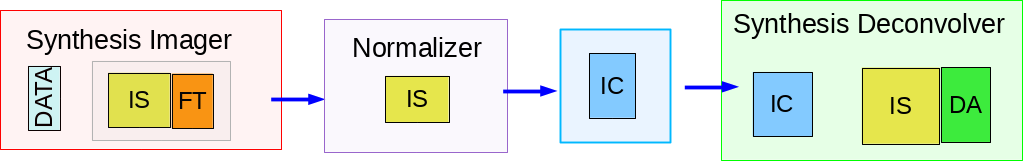
</div>


Figure 1 : Block diagram showing how the different modules within the CASA Imager interact for serial runs. 

#### Parallel Continuum 

For continuum imaging, the major cycle is parallelized by partitioning the data, gridding and imaging each subset separately and then performing a gather operation to combine the images and weights prior to normalization (Figure 2). Parallelization for continuum imaging may be triggered by starting mpicasa and specifying how many processes (nproc or cpu cores) are to be used. Out of these nproc cores, nproc-1 cpus are assigned to the major cycles and 1 processor acts as coordinator and runs the minor cycle iterations.  The visibility data (say it contains nrows rows) is divided along the row axis and each worker processor gets a partition to grid and FFT. Afterwards the coordinator processor collects the nproc-1 images, combines them and sends the residual/psf pair to the minor cycle (single processor). 

**NOTE**: In addition to starting mpicasa, for continuum imaging one has to also set the parameter parallel=True in tclean. If it is set to parallel=False it will run on only one cpu core (which may be slower than running in casa as is only in single thread mode)

<div>
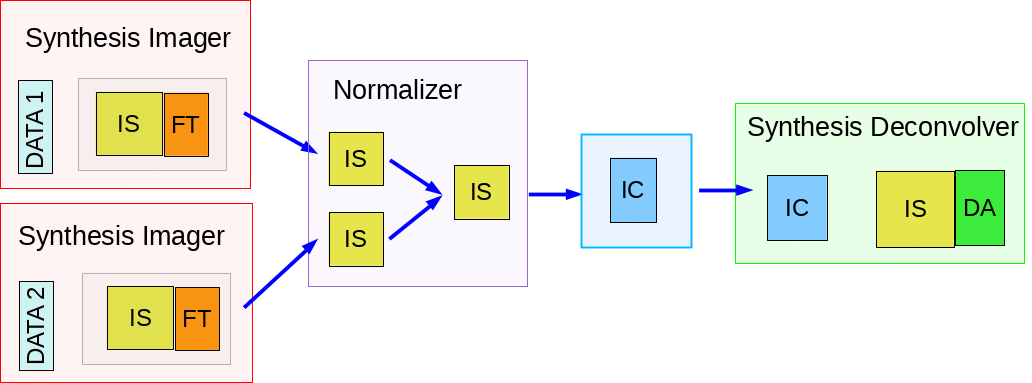
</div>


Figure 2 : Major cycles operate on separate data partitions, and a gather step is performed prior to normalization and the minor cycle. The corresponding reverse operations are done for the model predict step. 

#### Parallel Cube - Current

Parallelism is achieved by partitioning on image channels and processing each partition separately for both major and minor cycles (Figure 3). By design, all image cubes are partitioned by reference only, preserving the structure of the image cube as produced by a serial run.  The processing is in parallel (nproc -1 processors processing a partition each and writing back to a common product) or in serial (with the single processor processing one partition at a time). With this design the parallel and serial code uses the same code and pathways, including for iteration control.

<div>
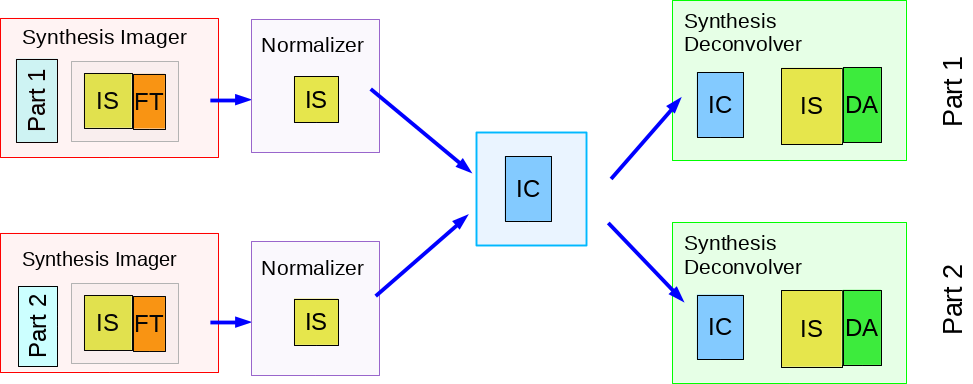
</div>

Figure 3 : Cube parallelization with synchronized iteration control. 


##### Major cycle partitioning:
The driving criterion here is to minimize the number of times we have to read the visibility data when making a residual image or psf. So ideally one would maximize the number of channels that can fit into memory for the gridding/degridding stage.  The amount of memory is a function of the size of the image and number of copies needed for different gridders. As of writing this document  it has been estimated that standard gridder may need the equivalent of 9 copies of single precision float images in memory to run without swapping, with wprojection needing 15 and mosaic needing 20. The partitioning for gridding uses these numbers to decide the number of channels per partition such that the all the required grid cubes fit in the memory available per processor.

##### Minor cycle partitioning :
Minor cycle partitions are chosen as the number of channels that fill an 8M pixel limit, with the finest granularity being 1 channel (i.e. when nchan=1 is itself > 8M pixels).  

The reasoning for this choice is as follows : Due to the way the minor cycle algorithms are designed especially when automasking is used (the whole partition of the cube or multiple copies of it may be loaded in memory) partitioning on one channel at a time would be ideal. But if the image is small and one plane minor cycle may take an amount of time which is comparable to locking and writing that plane back into a common image, parallel speed-up may be insignificant or even negative as compared to serial.  Experimentation on NRAO, Socorro lustre filesystem showed that if a partition contains at least 8 million pixels the locking time is not as significant as the processing time. 

Note : Minor cycle algorithms do not respect any limit set by .casarc (and they have never done so). Internally, even for a serial run, only one channel/plane is send for deconvolution at a time and so memory use is always governed by that required by one channel. 

##### Internal Implementation
This diagram (Figure 4) illustrates the code flow in the current cube imager in more detail. 
For more fine-grained information, please refer to [this development document](www.google.com).

<div>
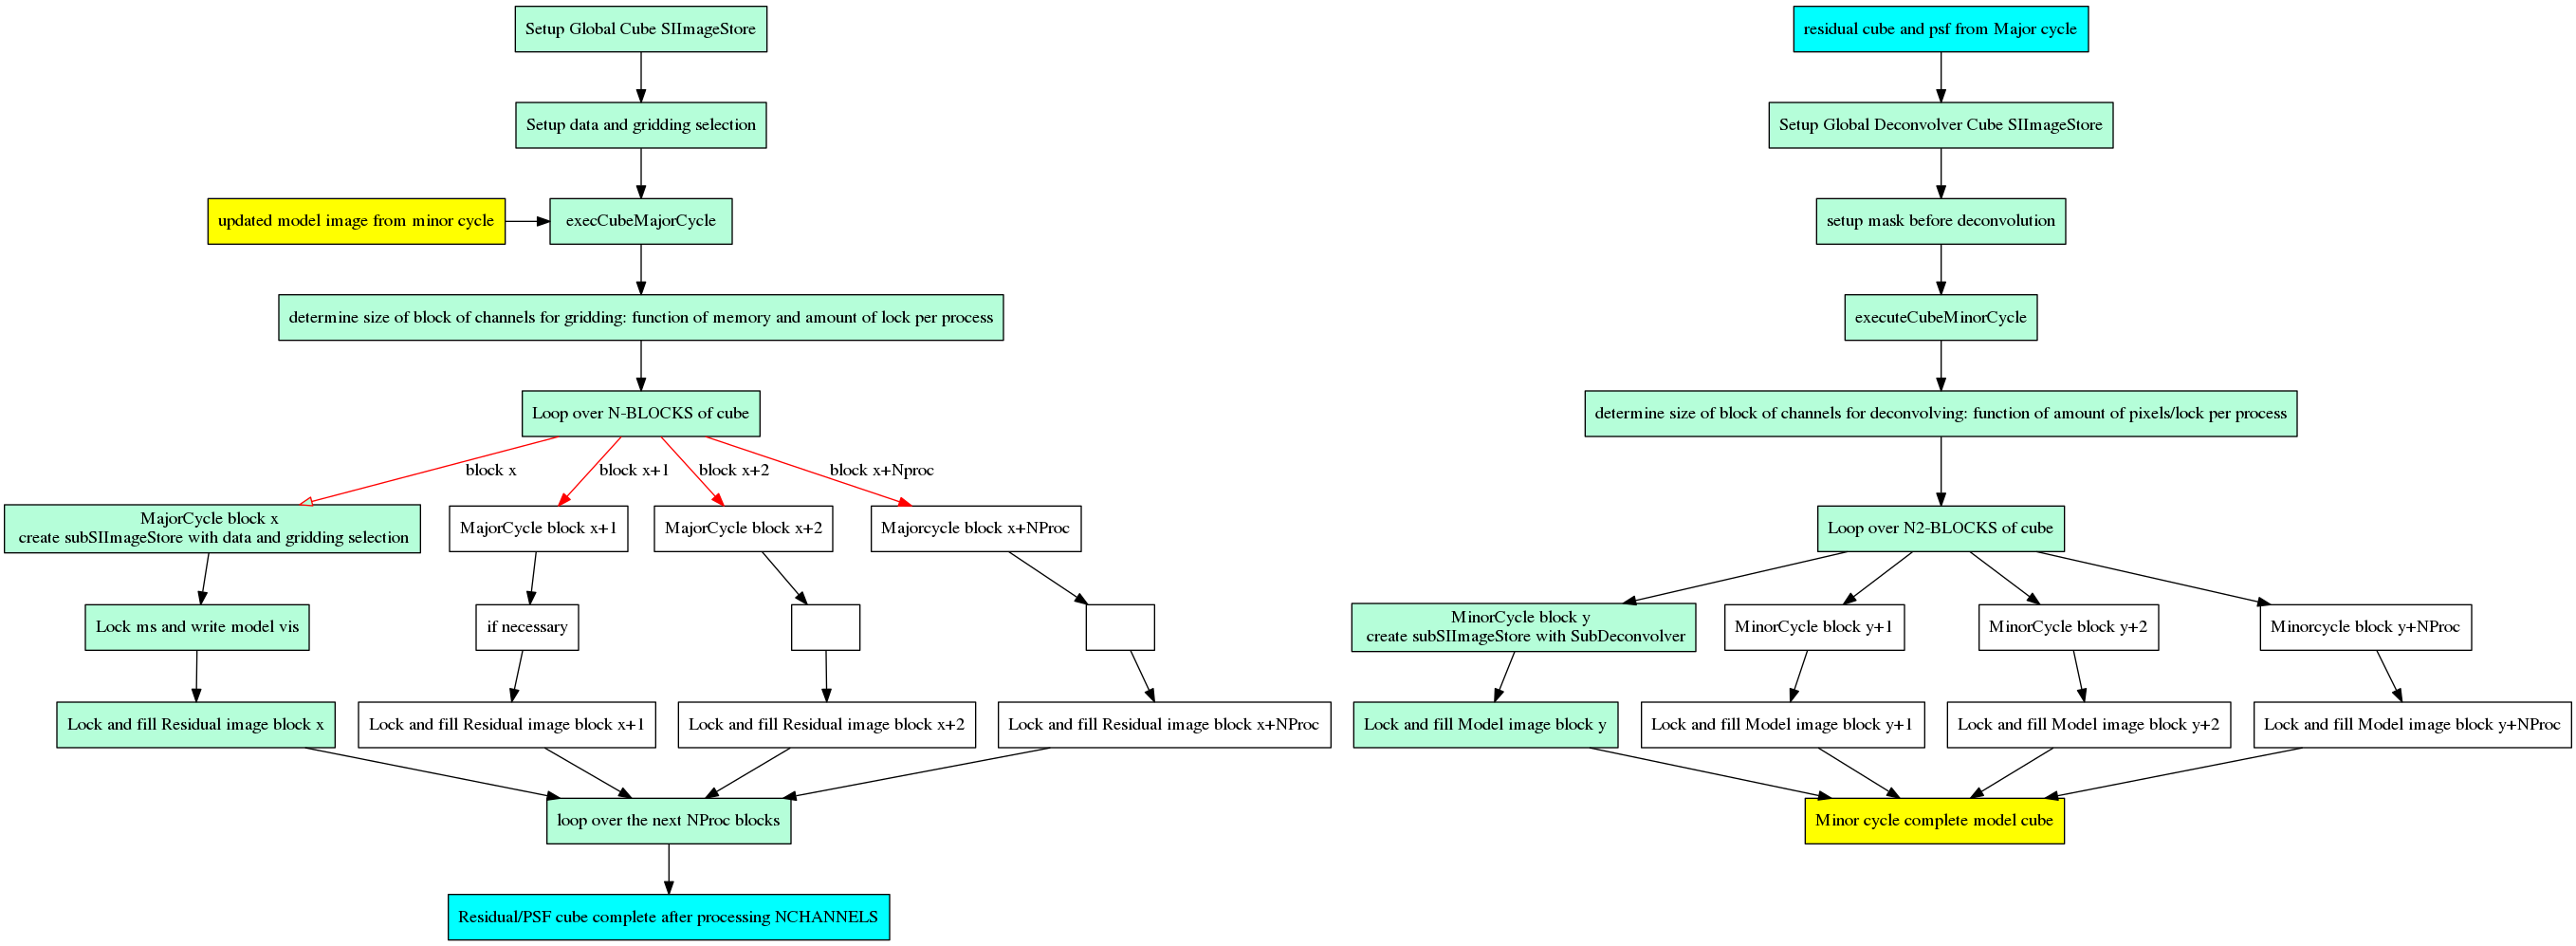
</div>

Figure 4 : Code flow diagram for the CASA Cube imager. 

##### Serial vs Parallel Runs
In CASA 6.2 onwards, cube imaging uses the same code for parallel and serial.  The partitioning used is always as defined above. In a serial run, partitions are iterated over in a loop, and in a parallel run they are run in parallel. 

 - casa  : Start casa in serial mode for cube imaging
    - Cube imaging is run in serial and the memory estimate (set by .casarc or cgroups) is interpreted as the amount available to a single processor. Multi threading is allowed by default (as this does not use extra memory) unless the user limits that by using the environment variable OMP_NUM_THREADS. 
 - mpicasa : Start casa in parallel mode for cube imaging
    - Cube imaging will use all the processes available by that invocation and multithreading is disabled. Here too, the .casarc or cgroups setting is used. Note that "mpicasa -n 1" is equivalent to a serial run limited to use only one thread. 

*Note* : The tclean parameter "parallel" is ignored for cube imaging. It will be removed in the future to make tclean conform to the convention used by all other tasks (parallel runs are triggered by starting casa via "mpicasa"). 


#### Parallel Cube - Old

In CASA 6.1 and earlier, parallel cube imaging was implemented as follows for all imaging modes. In CASA 6.2, only gridder=’awproject’ uses this mechanism for parallel cube imaging.

Figure 5 illustrates the old mechanism for cube parallelization. The image cube is partitioned along frequency, and the entire sequence of iterative image reconstruction is performed independently on each frequency chunk. At the end of the run, a reference-concatenated image is produced from the collection of image cubes per partition.

<div>
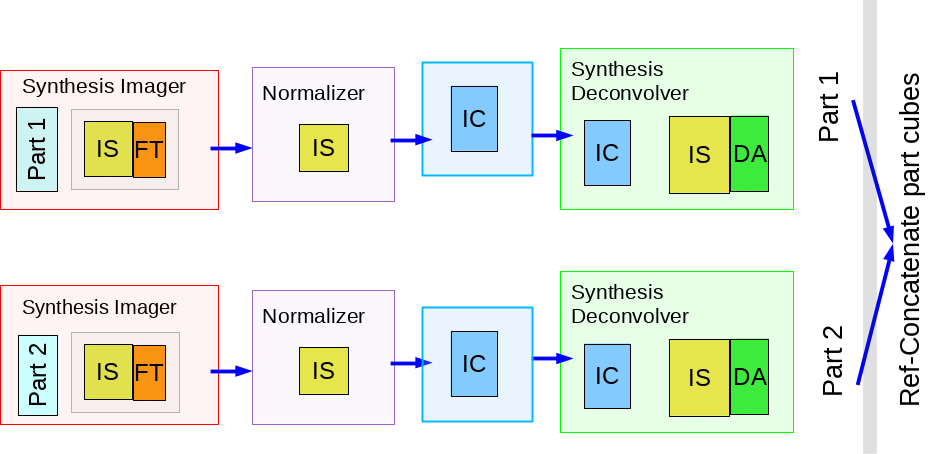
</div>

Figure 5 : Old implementation of Cube parallelization where iteration control runs independently per frequency partition. 


In this mode of operation, the iteration control is independent per chunk. Calculations of the cyclethreshold to trigger each major cycle rely on the peak residual across all channels seen by the deconvolver, which in this case is per partition. Numerical results could therefore differ between serial runs and parallel runs with different partitions of the cube, although all results would still be scientifically equivalent.  Interactive clean masking is not supported in this mode and different frequency chunking mechanisms (manual settings of channel chunks for serial runs and frequency partitioning for parallel) do not interact well with each other. The explicit partitioning of the image cubes prevents the ability to restart tclean for cubes with different numbers of processors, and writing the model column to disk was not easily possible.


In the CASA 6.2 development cycle, parallel cube imaging was refactored to address the above problems. The current implementation is depicted in Figures 3 and 4.

#### Current limitations 
For CASA 6.2, support for the AWProject gridder has not been included in the recent refactored cube imaging effort. It uses the older version of cube imaging code, for both serial and parallel execution. Based on verification tests, this mode does run, but it has failure modes that have not yet been fully evaluated or commissioned to be fully usable.  The following are warning messages meant to illustrate the situation. 

 - All cube+awproject runs : The gridder='awproject' has not been fully tested for 'cube' imaging (parallel=True or False). Formal commissioning of this mode is expected in a subsequent release, where 'awproject' will be aligned with recent framework changes. Until then, please report errors/crashes if seen.

 - When cube+awproject, started with mpicasa : Cube imaging with awproject does not use the same MPI mechanism as the other gridders (Figs 3 and 4 above). Instead it uses the previous approach for cube imaging (Fig 5 above). Additionally, when started with mpicasa, this imaging mode will produce an error at the end of the task that says 'parallel transport layer not initialized'. Please ignore this for now as it occurs after all computations are complete and outputs are on disk. 

Parallel continuum imaging is suppor

Full support for AWProject with Cube imaging is planned for an upcoming release.  Note that this gridder has been classified as experimental for some time and although it has been commissioned for VLASS (and VLA) continuum in a recent release, it has never been commissioned for cube imaging along with cube partitioning using the channel-chunking mechanism.  

### Setup and Usage <a id=’Usage’></a>

#### Choosing the number of threads 
Multi-threading runs automatically when invoking casa and calling any imaging tasks (tclean, deconvolver). CASA uses the FFTW library which runs any FFT calls on multiple cores using threads. Some gridders in the major cycle of tclean also run on multiple threads (standard, wproject, mosaic) using OpenMP. The multi-scale clean minor cycle also employs multi-threading across scales. Multi-threading (on one node) uses shared memory and does not consume more memory than when run on a single thread. 

The maximum number of threads (or cores) used can be controlled by the user by using the environment variable OMP_NUM_THREADS.

The default number of threads depends on how one starts casa.
 - "**casa** : The default is to use all the cores available on a node when possible. OpenMP multi-threading may be turned off (if needed) by launching casa as follows in a bash shell " OMP_NUM_THREADS=1 casa " or by setting the OMP_NUM_THREADS environment variable to 1. This will force all fft calls and tclean etc to use only 1 core. 
 - "**mpicasa**" : The default setting for OMP_NUM_THREADS is 1. While it is possible to set this to a larger number, the combined use of multi-threading and multi-processing has not been tested and is currently not recommended. 



#### Choosing the number of processes 

Parallelization mechanisms include python level management of jobs using mpi4py (for some situations) and C++ level MPI calls (for other situations). 

 - For CASA 5.7/6.1 and previous versions, both continuum and cube parallelization use mpi4py, implemented as shown in Figures 2 and 5 respectively.  
 - From CASA 5.8/6.2, cube parallelization uses MPI from C++, implemented as shown in Figures 3 and 4, for all imaging modes except the awproject gridder.
 - Future releases : We expect to enable awproject with the current cube imager, and also provide an option for continuum parallelization that uses cube major cycles. 
 

To use multi-processing one has to invoke casa via the mpicasa call. Please refer to this [documentation on how to use multiple nodes given](https://casadocs.readthedocs.io/en/latest/notebooks/parallel-processing.html).

In its simplest form, multi-processing may be invoked as

mpicasa  -n  nproc   full-path-to-casa-binary 

Note : mpicasa will automatically disable multithreading by setting OMP_NUM_THREADS=1.

#### Choosing Memory Limits

The minimum amount of memory required for cube imaging is controlled by what is currently used for 1 image channel. But, beyond that amount, a user can limit the amount of memory used by the cube imaging code as follows.

 - Define a system.resources.memory variable in the $HOME/.casarc file. For example, setting " system.resources.memory: 10000 " will limit the CASA Imager to 10GB of RAM during cube major and minor cycles. Another way of specifying a memory limit is to specify the allowed fraction of total memory to be used via the "system.resources.memfrac" variable. For more details on defining these variables please refer to the [CASA startup configuration](www.google.com) documentation. 
      
 - If the system.resources.memory variable is not defined, the cgroups settings are used/read. On the multi-node cluster the user or system can control resources via cgroups setting. For more info at NRAO, please refer to [documentation on running cluster jobs](https://info.nrao.edu/computing/guide/cluster-processing/access-and-running-jobs) and [instructions on setting resource limits](https://info.nrao.edu/computing/guide/cluster-processing/resource-limits-and-data-retention).

 - If no .casarc or cgroups values are defined then all the memory on a node (as reported the the operating system) will be assumed as available for use.

**Note**: if the limit given in .casarc (or via the cgroups setting) is smaller than what is needed to process 1 full image channel then the usage might exceed that requested .casarc limit if the memory is physically available on the node. Otherwise it will swap as needed. 

**Note** : Continuum imaging and deconvolution have not been tested against these settings and are generally not expected to follow these constraints yet. 

#### When can a parallel run seem slower than expected ?

Parallelization is usually expected to offer a beneficial* speed-up. 

However, there are some conditions when running in parallel are not expected to have much speedup. Mainly, when the I/O time is significant compared with compute time, the gains from compute parallelization are not useful and the overheads of setting up the parallelization will dominate. 

 - **The visibility data set is small** : CPU time to grid/degrid the data is just a few multiples of the time needed to read the visibilities from disk 
 
 - **The output cube has only a few channels per processor available** : The amount of time a processor has to wait to write the results in an image is comparable to the time it takes to write the data. It is therefore more efficient to choose a number of processors such that the number of channels per partition is large enough (approximately 8e+6 pixels in all)
 
 - **Not enough memory per processor** : This forces the processing to have only a few channels per partition, and it suffers from the issue mentioned in the previous point. This may be triggered by restrictions applied via .casarc and cgroups. 
 
 - **Slow disk** : This in general brings the IO time up
 
 - **Model visibilities to be written in the Measurement sets** (savemodel=’modelcolumn’) : Model data writes are done by locking the data sets such that only one processor can write at a time. Based on one verification test, our measurements for CASA 6.2 show that the saving of the model column produced a 20% increase in runtime for a run with 2 major cycles, in which the model is written in the second cycle.  (This was also measured to be a factor of 2 improvement over the situation for CASA 6.1). 
 

*A future version of this documentation will include information about measured/demonstrated performance gains under some commonly-encountered situations. 

#### Comparing data products with different choices of parallelization

 - Numerically Identical runs 
   - In CASA 6.2, measurements have shown identical output between runs with mpicasa that use different numbers of processors.  That is, runs with mpicasa -n X where X>1 produce identical results as mpicasa -n 1 (equivalent serial run). 

 - Numerically Different runs (single precision level) 
     - In CASA 6.2, there is a measurable difference at the single precision level between all serial runs started with ‘casa’ versus as ‘mpicasa -n 1’.  
     - In CASA 5.8, there is no difference between serial and parallel runs (if automasking is turned off), but a difference at the single precision level appears if automasking is turned on.  
     - CASA 6.2 and CASA 5.8 differ at the single precision level, for runs set up in the same way. This is likely due to differences in third party libraries, and should be kept in mind for all casa5 vs casa6 comparisons since CASA versions 5.6 and 6.0. 

Note : In CASA 6.1 and earlier, numerical differences for cube imaging between serial and parallel were larger than any of the above differences, owing to the fact that iteration control was implemented differently for serial and parallel. This has been synchronized (logically) with serial cube imaging, in CASA 6.2, by switching from the modes shown in Fig 3 to Fig 4. 

For more details on comparison and performance tests please read [this document](www.google.com).

## Bibliography

1. J. A. Hogbom 1974 (http://adsabs.harvard.edu/full/1974A%26AS...15..417H)
2. B. G. Clark 1980 (http://adsabs.harvard.edu/abs/1980A%26A....89..377C)
3. F. R. Schwab, 1984 (http://adsabs.harvard.edu/abs/1984AJ.....89.1076S)
4. T. J. Cornwell, 2008 (http://ieeexplore.ieee.org/document/4703304/)
5. U.Rau, 2011 (https://www.aanda.org/articles/aa/abs/2011/08/aa17104-11/aa17104-11.html)
6. T. J. Cornwell, 2008 (http://ieeexplore.ieee.org/document/4703511/)
7. S. Bhatnagar, 2008 (http://adsabs.harvard.edu/abs/2008A&A...487..419B)
8. S.Bhatnagar, 2013 (http://adsabs.harvard.edu/abs/2013ApJ...770...91B)
9. T. J. Cornwell, 1988 (http://adsabs.harvard.edu/abs/1988A%26A...202..316C)
10. Briggs D.S. 1999 ([Astron. Soc. Pac. Conf. Ser.](http://www.aspbooks.org/publications/180/127.pdf))
11. Cornwell, T.J 1999 ([Astron. Soc. Pac. Conf. Ser.](http://www.aspbooks.org/publications/180/151.pdf))
12. Cornwell, T.J., "The Generic Interferometer: II Image Solvers", Aips++ note 184. Aug 1995
13. U.Rau, 2009 (http://ieeexplore.ieee.org/document/5109712/)
14. Briggs D., 1995, PhD Thesis, New Mexico Institute of Mining and Technology
15. Schwab and Cotton 1983 
16. Hogbom 1974
17. Clark 1980
18. Cornwell 2008
19. Rau & Cornwell 2011
20. Cornwell and Evans 1985
21. Narayan and Nityananda 1986
22. Bhatnagar and Cornwell 2004
23. Kepley et al. 2020, Publications of the Astronomical Society of the Pacific, 132, 024505 
24. Peirce, B. 1852, The Astronomical Journal, 2, 161. 
25. Chauvenet, W. A Manual of Spherical and Practical Astronomy, Volume II (London, UK: Dover; reprinted in 1960 based on fifth revised and corrected edition 1891), 558--566
26. Rau & Cornwell (2011), A&A 532, A71 (http://adsabs.harvard.edu/abs/2011A%26A...532A..71R)
27. Sault et al, 1999 (https://ui.adsabs.harvard.edu/#abs/1999A&AS..139..387S/abstract)
28. Cornwell et al, 2008 (https://ui.adsabs.harvard.edu/#abs/2008ISTSP...2..647C/abstract)
29. Bhatnagar et al, 2008 (https://ui.adsabs.harvard.edu/#abs/2008A&A...487..419B/abstract)
30. Kundert et al 2016 (http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7762834&tag=1) 
31. Napier and Rots, 1982 (https://library.nrao.edu/public/memos/vla/test/VLAT_134.pdf)
32. Perley 2016 (https://library.nrao.edu/public/memos/evla/EVLAM_195.pdf)
33. Brisken 2009 (https://ui.adsabs.harvard.edu/#abs/2009nsem.confE..21B/abstract)


